In [1]:
!pip install ctab-xtra-dp==3.6.0

In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from ctab_xtra_dp import evaluation
from utils import  plot_single_dataframe , compare_dataframes


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np




def compare_dataframes(
    df: pd.DataFrame,
    syn: pd.DataFrame,
    nominal_values: dict,
    categorical_columns: list = None,
    columns: list = None
):
    """
    Compare each column in df and syn using:
    - Histogram if the column has continuous data
    - Bar chart if the column has categorical data

    Mixed columns are plotted alone; one-type columns (cat or cont only) are plotted two per row.
    """
    categorical_columns = categorical_columns or []
    columns_to_plot = columns if columns is not None else df.columns
    one_part_buffer = []

    num_bins = 50  # Number of histogram bins

    def plot_one_part_pair(pair, num_bins):
        plt.figure(figsize=(14, 5))
        for i, (col, cat_vals, cont_vals, is_cat) in enumerate(pair):
            plt.subplot(1, 2, i + 1)
            if is_cat:
                all_categories = set(cat_vals[0].unique()).union(set(cat_vals[1].unique()))
                orig_counts = cat_vals[0].value_counts().reindex(all_categories, fill_value=0)
                syn_counts = cat_vals[1].value_counts().reindex(all_categories, fill_value=0)
                width = 0.35
                x = np.arange(len(all_categories))
                plt.bar(x - width / 2, orig_counts.values, width=width, label='Original', edgecolor='black')
                plt.bar(x + width / 2, syn_counts.values, width=width, label='Synthetic', edgecolor='black')
                plt.xticks(ticks=x, labels=all_categories, rotation=45, fontsize=15)
                plt.yticks(fontsize=15)
                plt.title(f'{col} (Categorical)', fontsize=18)
                plt.xlabel('Category', fontsize=18)
                plt.ylabel('Count', fontsize=18)
                plt.legend(fontsize=15)
            else:
                bin_edges = np.histogram_bin_edges(np.concatenate([cont_vals[0], cont_vals[1]]), bins=num_bins)
                plt.hist(cont_vals[0], bins=bin_edges, alpha=0.6, label='Original', edgecolor='black')
                plt.hist(cont_vals[1], bins=bin_edges, alpha=0.6, label='Synthetic', edgecolor='black')
                plt.title(f'{col} (Continuous)', fontsize=18)
                plt.xlabel('Value', fontsize=18)
                plt.ylabel('Frequency', fontsize=18)
                plt.xticks(fontsize=15)
                plt.yticks(fontsize=15)
                plt.legend(fontsize=15)
        plt.tight_layout()
        plt.show()

    for col in columns_to_plot:
        original = df[col]
        synthetic = syn[col]

        if col in categorical_columns:
            cat_orig = original.fillna('NaN').astype(str)
            cat_syn = synthetic.fillna('NaN').astype(str)
            cont_orig = cont_syn = pd.Series(dtype=float)
        else:
            mixed_values = nominal_values.get(col, [])

            def split_series(series, mixed_values):
                is_categorical = series.apply(
                    lambda x: any((pd.isna(val) and pd.isna(x)) or (str(x) == str(val)) for val in mixed_values)
                )
                categorical = series[is_categorical].fillna('NaN')
                continuous = pd.to_numeric(series[~is_categorical], errors='coerce').dropna().astype(float)
                return categorical, continuous

            cat_orig, cont_orig = split_series(original, mixed_values)
            cat_syn, cont_syn = split_series(synthetic, mixed_values)

        has_cont = not cont_orig.empty or not cont_syn.empty
        has_cat = not cat_orig.empty or not cat_syn.empty

        # Case 1: Mixed → full-row layout
        if has_cat and has_cont:
            plt.figure(figsize=(14, 6))
            # Continuous plot
            plt.subplot(1, 2, 1)
            bin_edges = np.histogram_bin_edges(np.concatenate([cont_orig, cont_syn]), bins=num_bins)
            plt.hist(cont_orig, bins=bin_edges, alpha=0.6, label='Original', edgecolor='black')
            plt.hist(cont_syn, bins=bin_edges, alpha=0.6, label='Synthetic', edgecolor='black')
            plt.title(f'{col} (Continuous)', fontsize=18)
            plt.xlabel('Value', fontsize=15)
            plt.ylabel('Frequency', fontsize=18)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            plt.legend(fontsize=15)

            # Categorical plot
            plt.subplot(1, 2, 2)
            all_categories = set(cat_orig.unique()).union(set(cat_syn.unique()))
            orig_counts = cat_orig.value_counts().reindex(all_categories, fill_value=0)
            syn_counts = cat_syn.value_counts().reindex(all_categories, fill_value=0)
            width = 0.35
            x = np.arange(len(all_categories))
            plt.bar(x - width / 2, orig_counts.values, width=width, label='Original', edgecolor='black')
            plt.bar(x + width / 2, syn_counts.values, width=width, label='Synthetic', edgecolor='black')
            plt.xticks(ticks=x, labels=all_categories, rotation=45, fontsize=15)
            plt.yticks(fontsize=15)
            plt.title(f'{col} (Categorical)', fontsize=18)
            plt.xlabel('Category', fontsize=18)
            plt.ylabel('Count', fontsize=18)
            plt.legend(fontsize=15)

            plt.tight_layout()
            plt.show()

        # Case 2: Only categorical or continuous → buffer for side-by-side plotting
        elif has_cat:
            one_part_buffer.append((col, (cat_orig, cat_syn), None, True))
        elif has_cont:
            one_part_buffer.append((col, None, (cont_orig, cont_syn), False))

        if len(one_part_buffer) == 2:
            plot_one_part_pair(one_part_buffer, num_bins)
            one_part_buffer = []

    # Plot final leftover column if odd number
    if len(one_part_buffer) == 1:
        plot_one_part_pair([one_part_buffer[0]], num_bins)



Fake data: ../data_generation/synthetic_data/adult_target_epochs_100_epsilon_None.csv


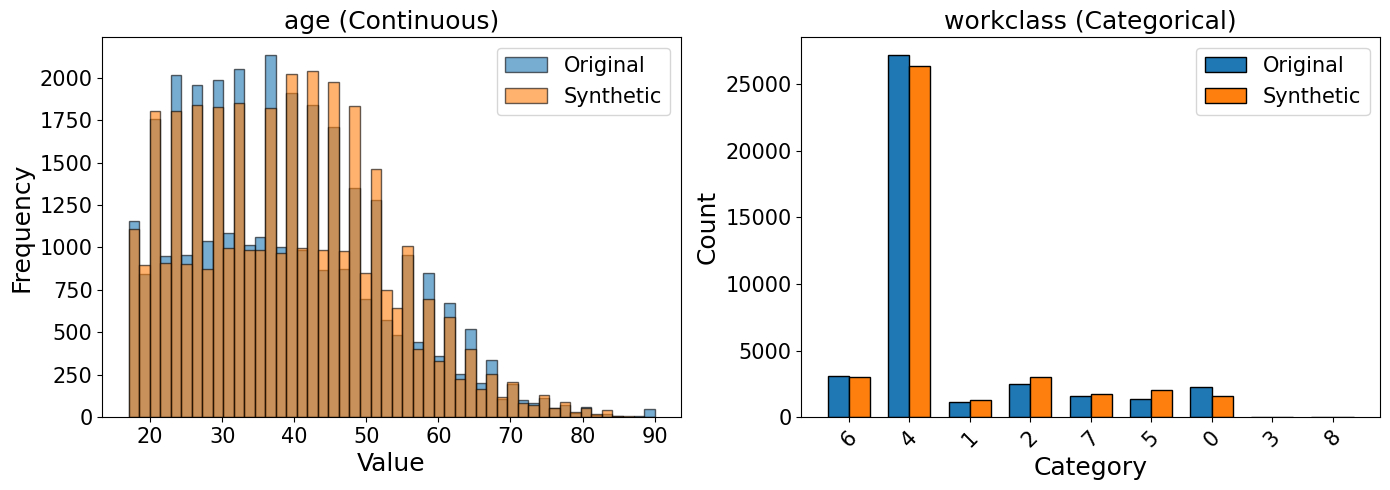

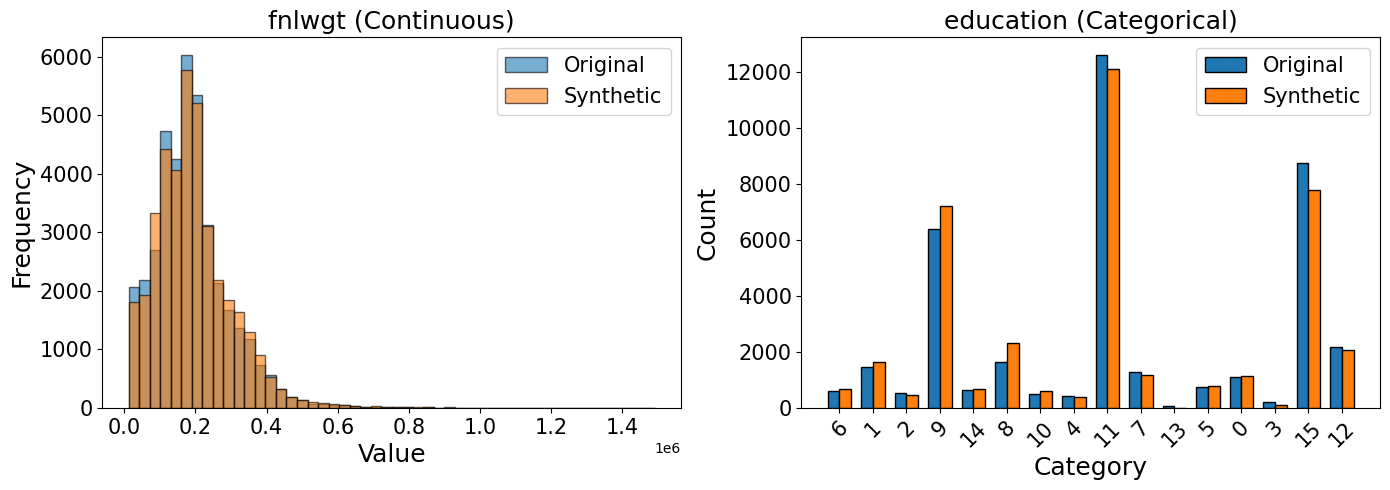

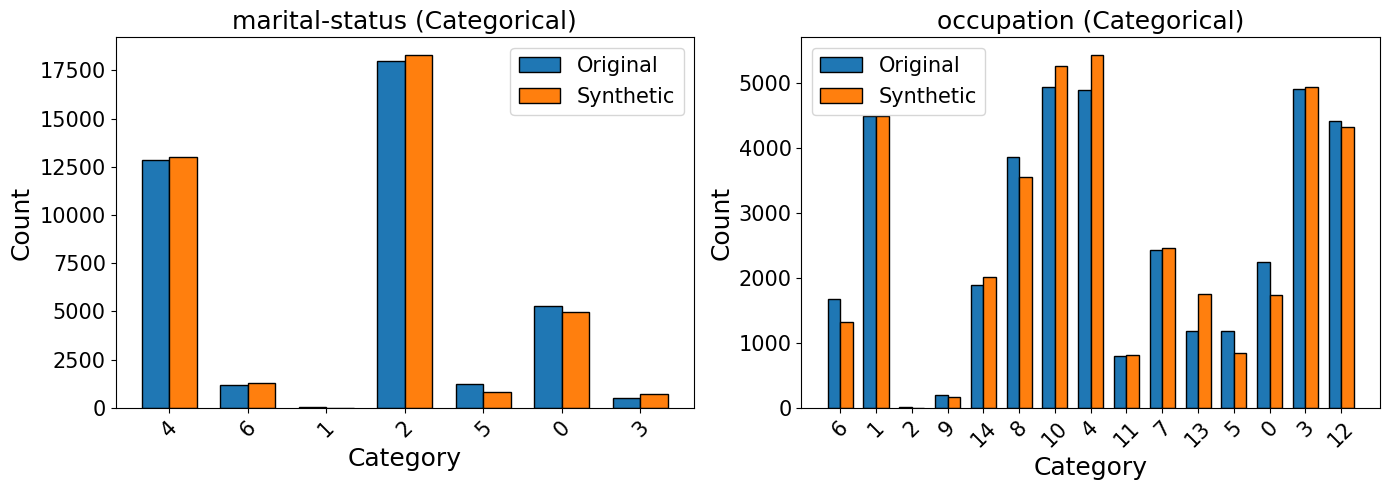

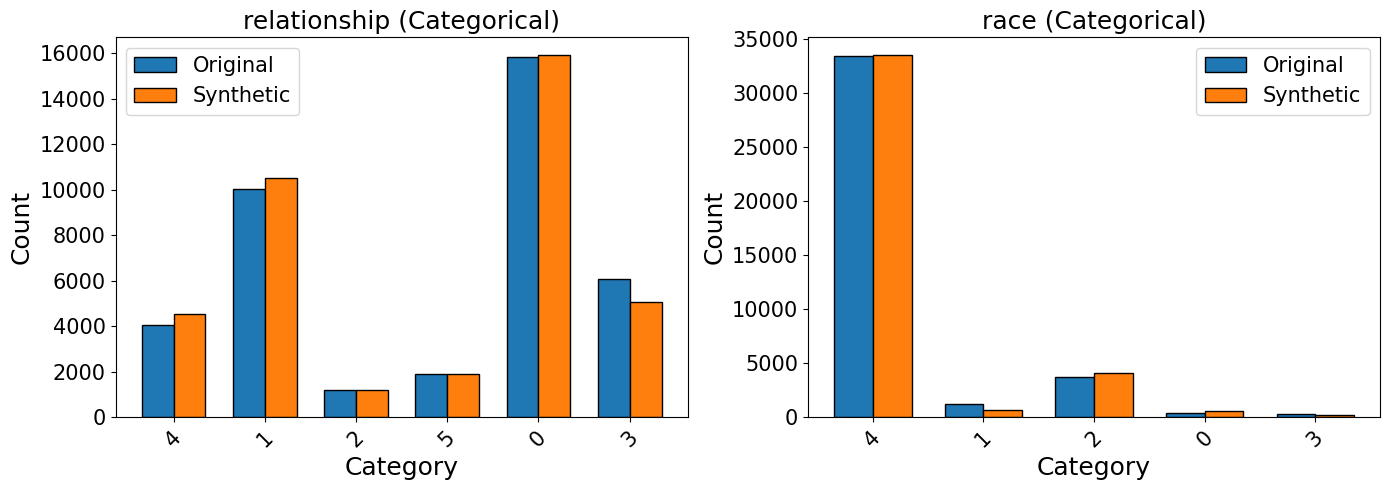

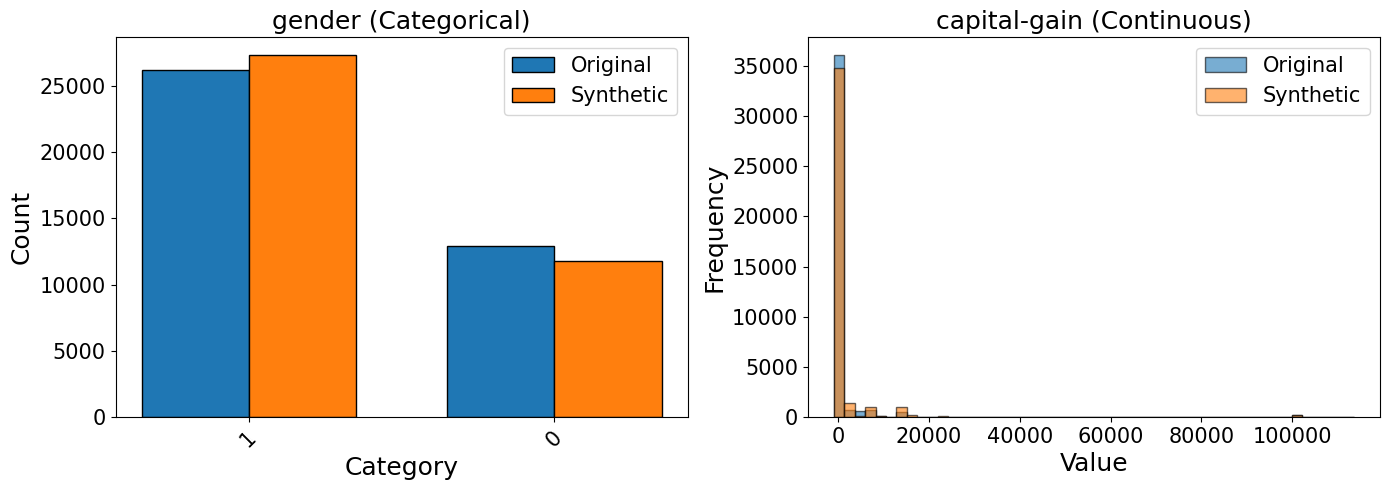

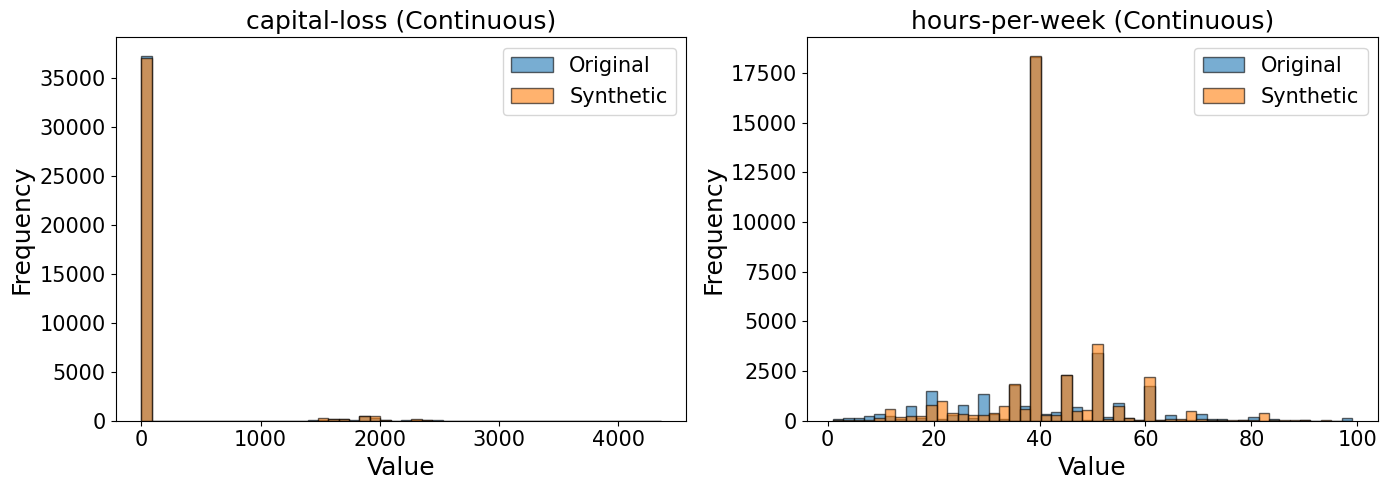

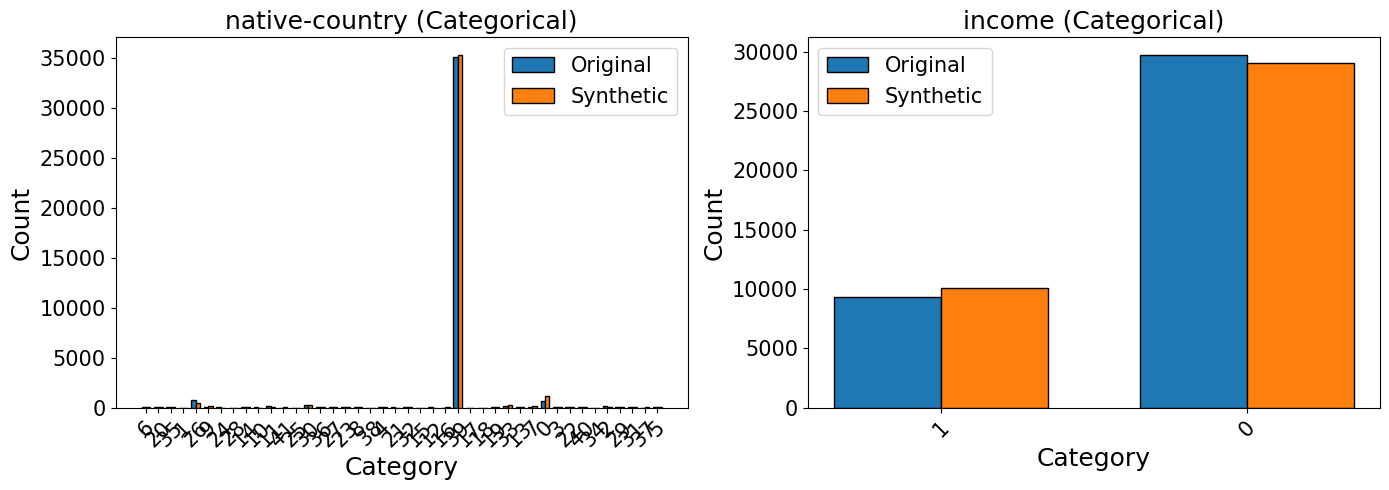

--------------


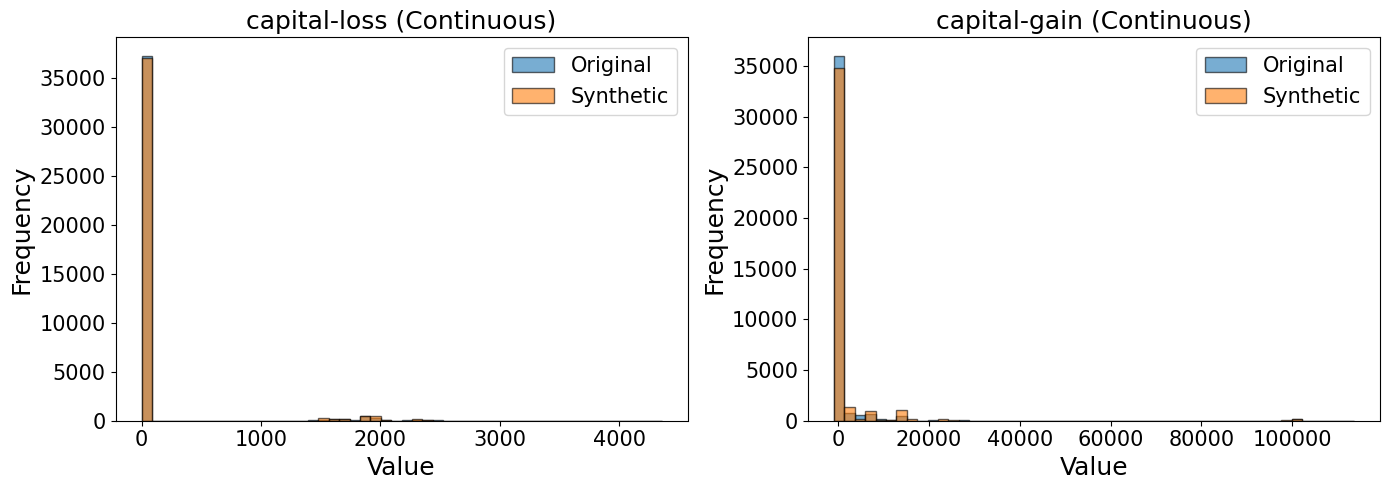

--------------


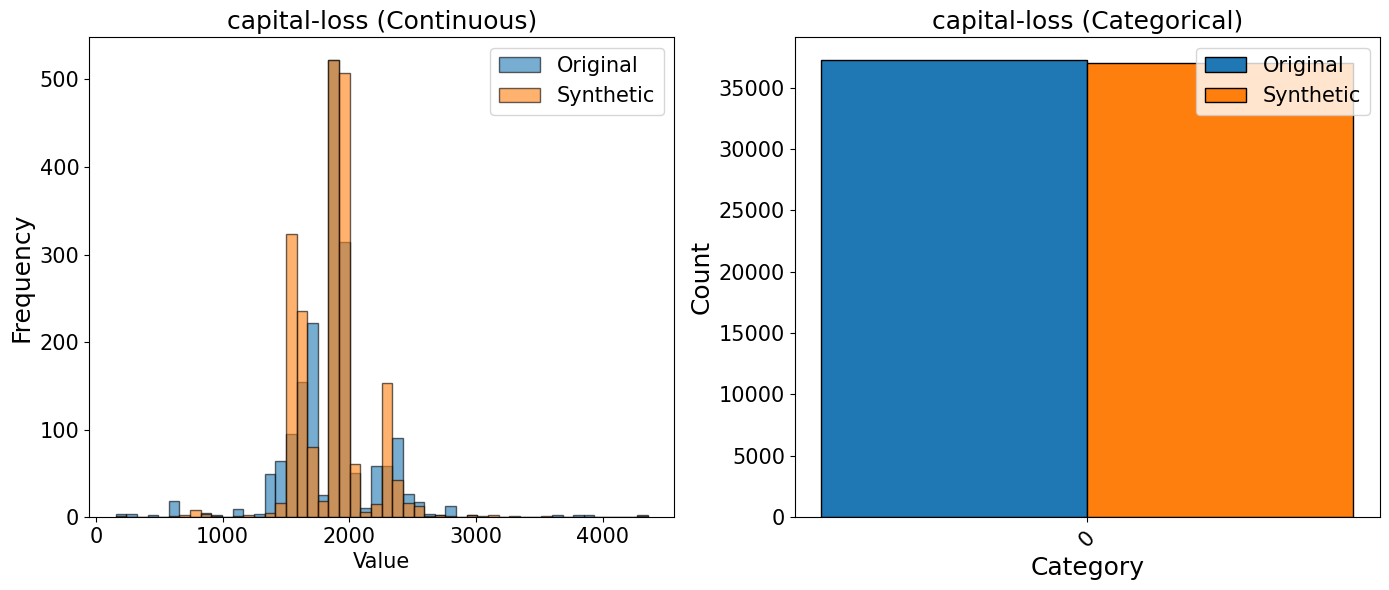

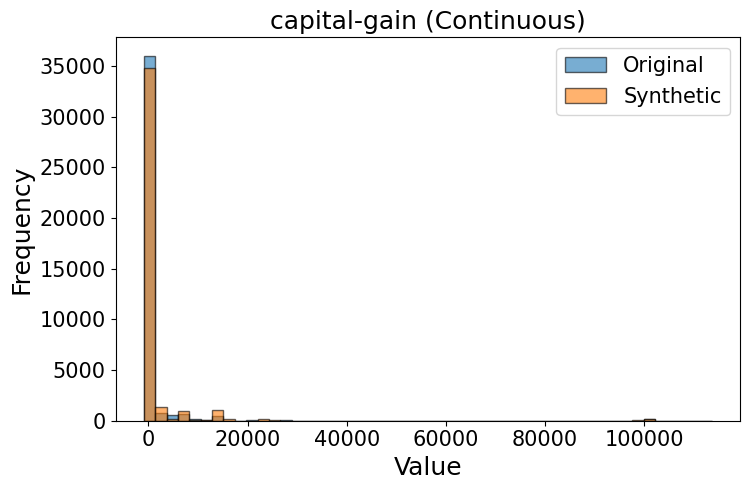

--------------


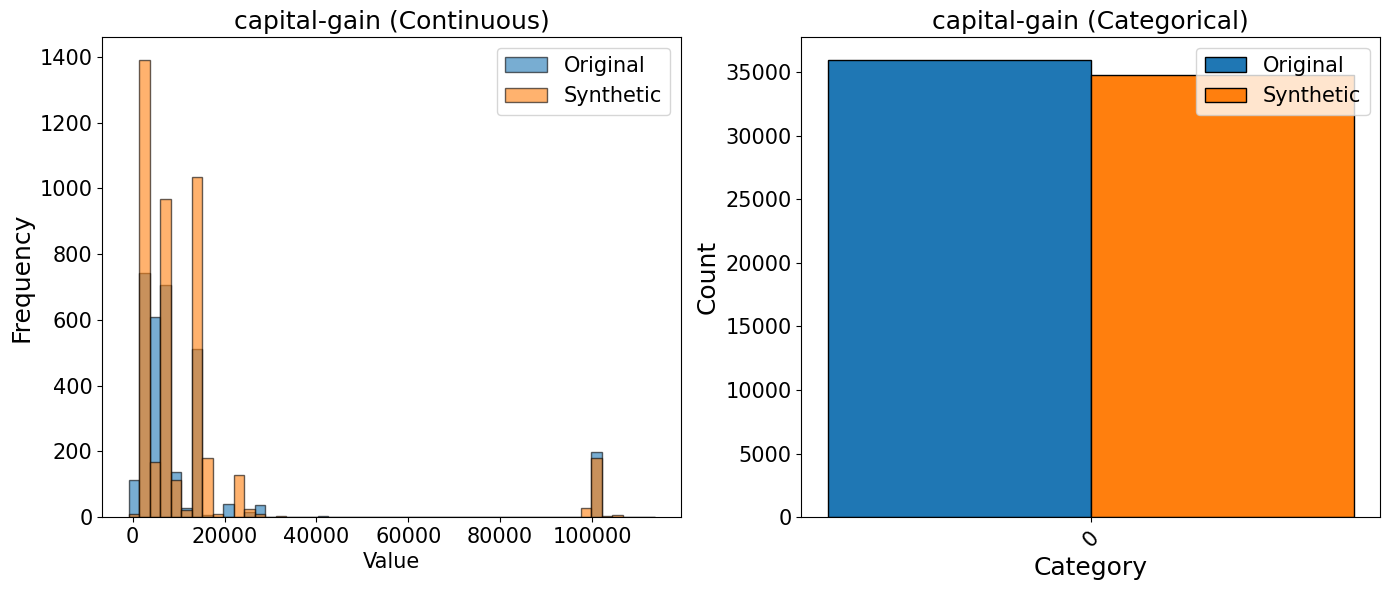

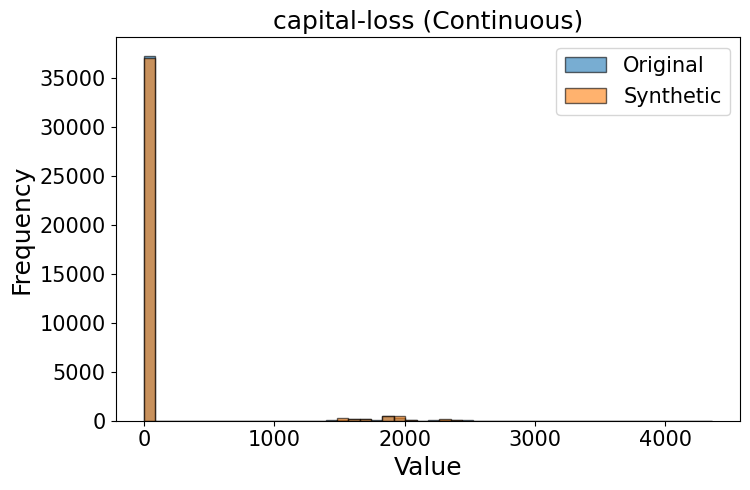

--------------


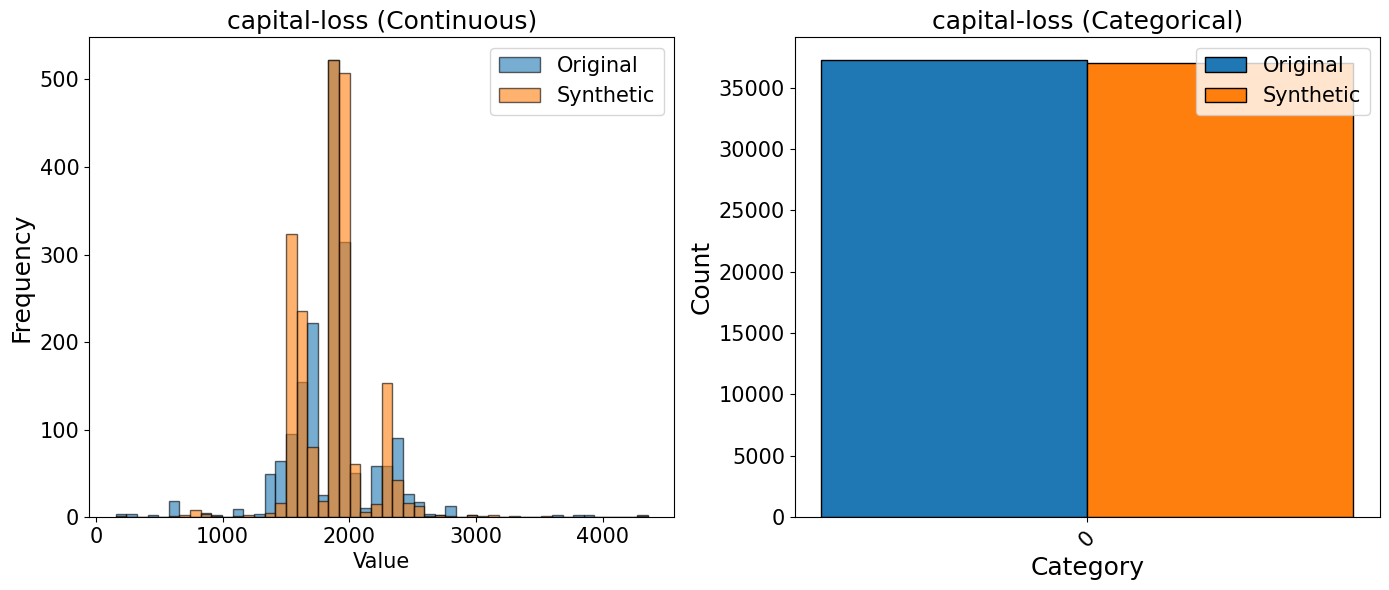

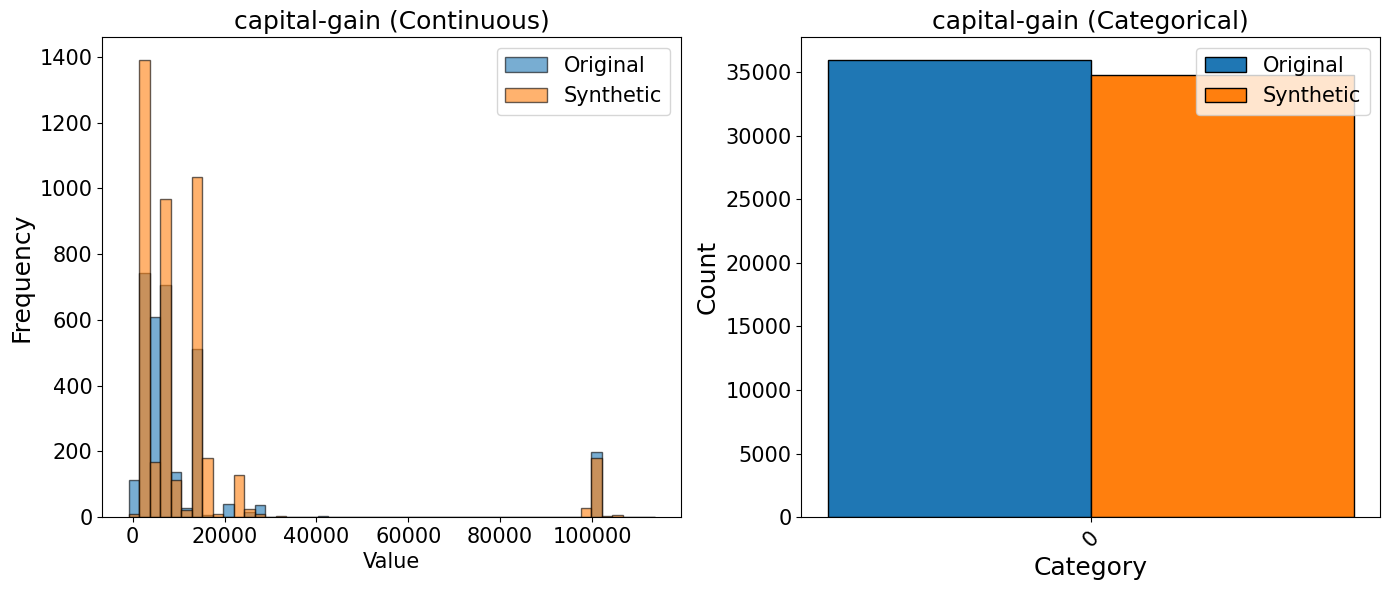

In [14]:


real = pd.read_csv('../datasets/Adult.csv')

categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                         'relationship', 'race', 'gender', 'native-country','income']

train, test = evaluation.split_data(real, 0.2, "income",random_state=22)

fakes = [
    '../data_generation/synthetic_data/adult_target_epochs_100_epsilon_None.csv',
    '../data_generation/synthetic_data/adult_target_epochs_100_epsilon_15.csv',
    '../data_generation/synthetic_data/adult_target_epochs_100_epsilon_5.csv',
    '../data_generation/synthetic_data/adult_target_epochs_100_epsilon_1.csv',
]


for fake_path in fakes:
    fake = pd.read_csv(fake_path)
    print(f'Fake data: {fake_path}')
    compare_dataframes(train,fake,{},categorical_columns=categorical_columns)
    print("--------------")
    compare_dataframes(train,fake,{},categorical_columns=categorical_columns,columns=["capital-loss","capital-gain"])
    print("--------------")
    compare_dataframes(train,fake,{"capital-loss": [0]},categorical_columns=categorical_columns,columns=["capital-loss","capital-gain"])
    print("--------------")
    compare_dataframes(train,fake,{"capital-gain": [0]},categorical_columns=categorical_columns,columns=["capital-loss","capital-gain"])
    print("--------------")
    compare_dataframes(train,fake,{"capital-loss": [0],"capital-gain": [0]},categorical_columns=categorical_columns,columns=["capital-loss","capital-gain"])
    
    break
    


Fake data: ../data_generation/synthetic_data/king_epochs_100_epsilon_None.csv


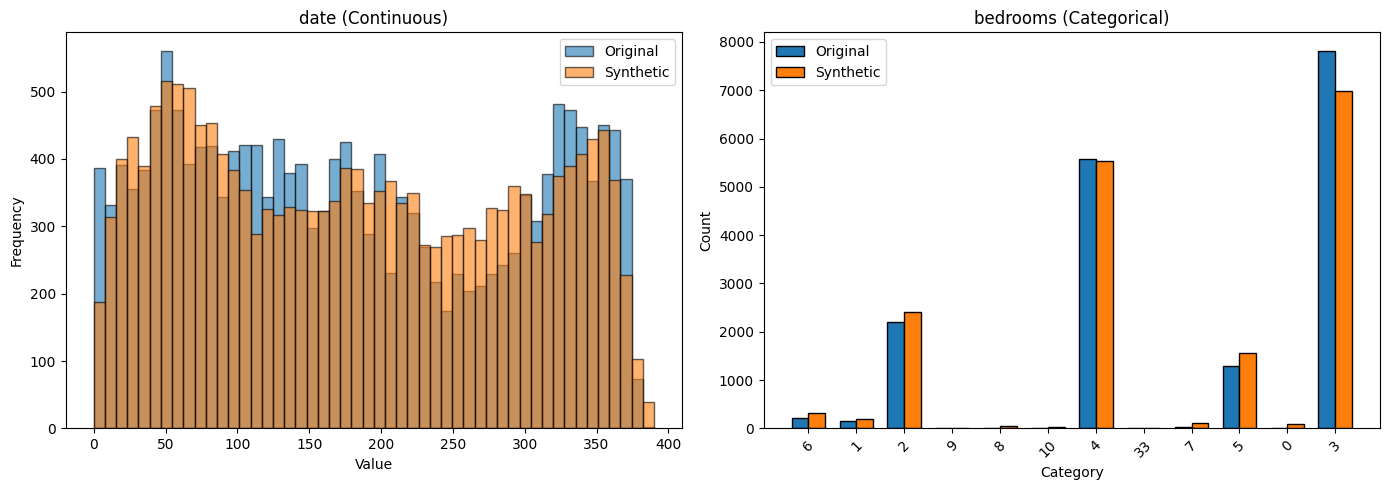

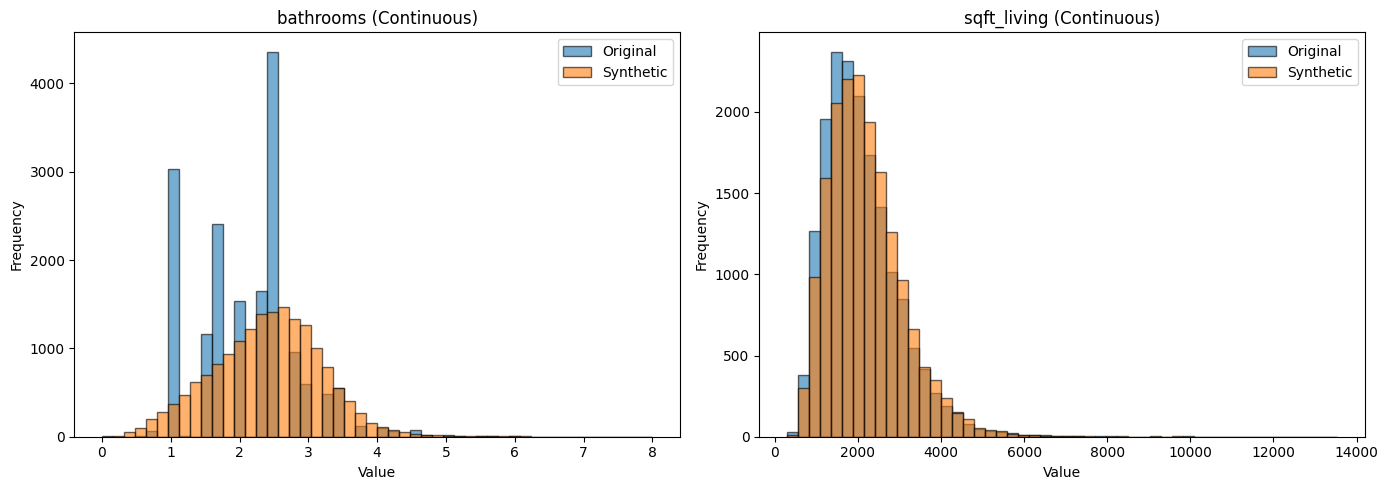

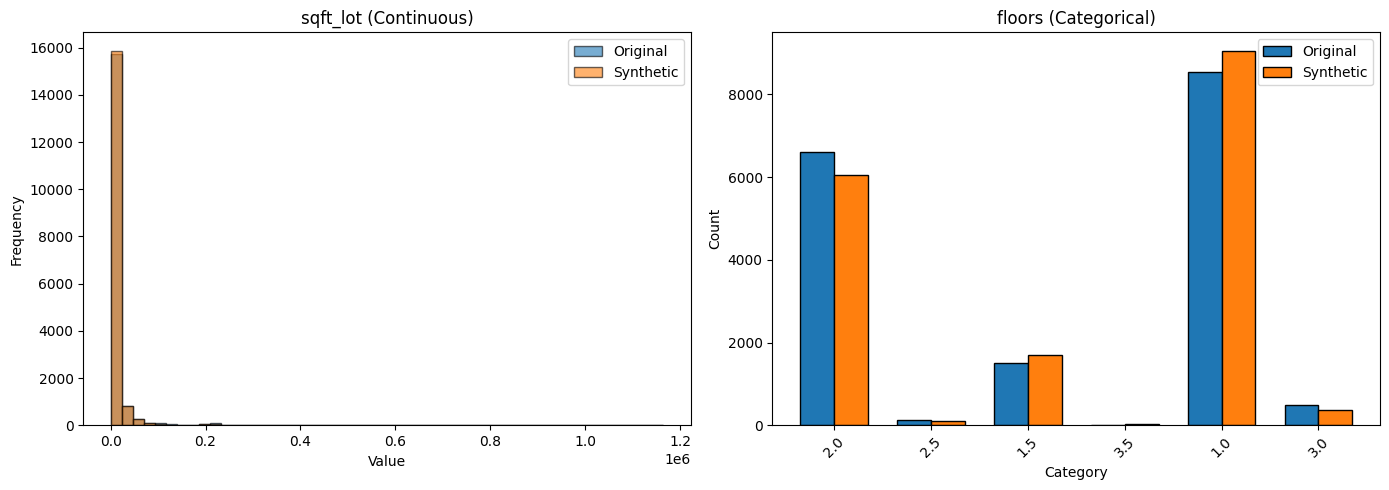

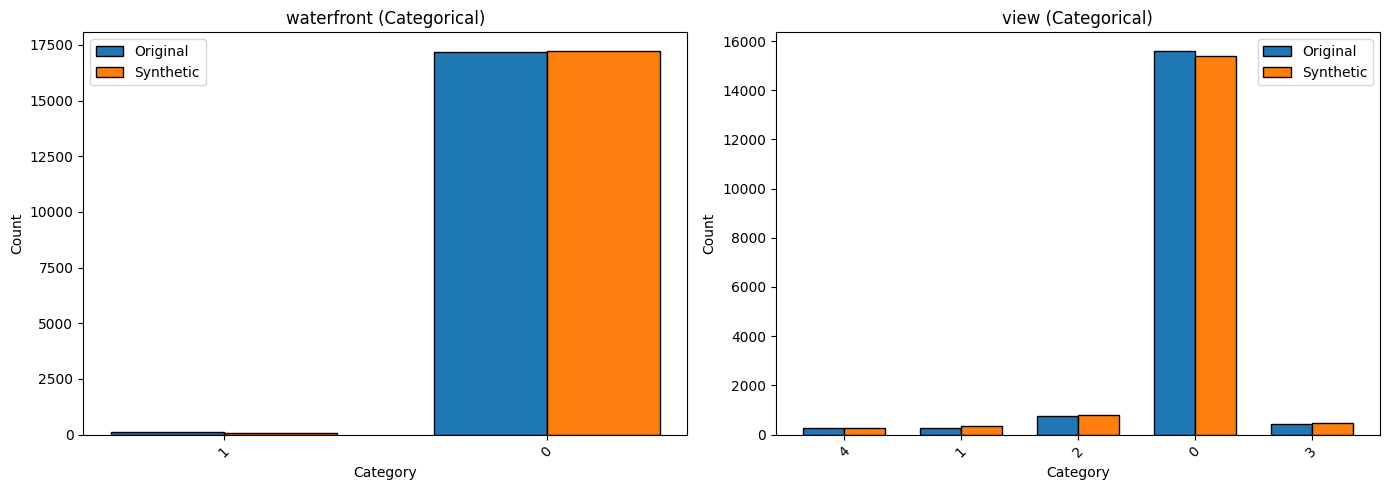

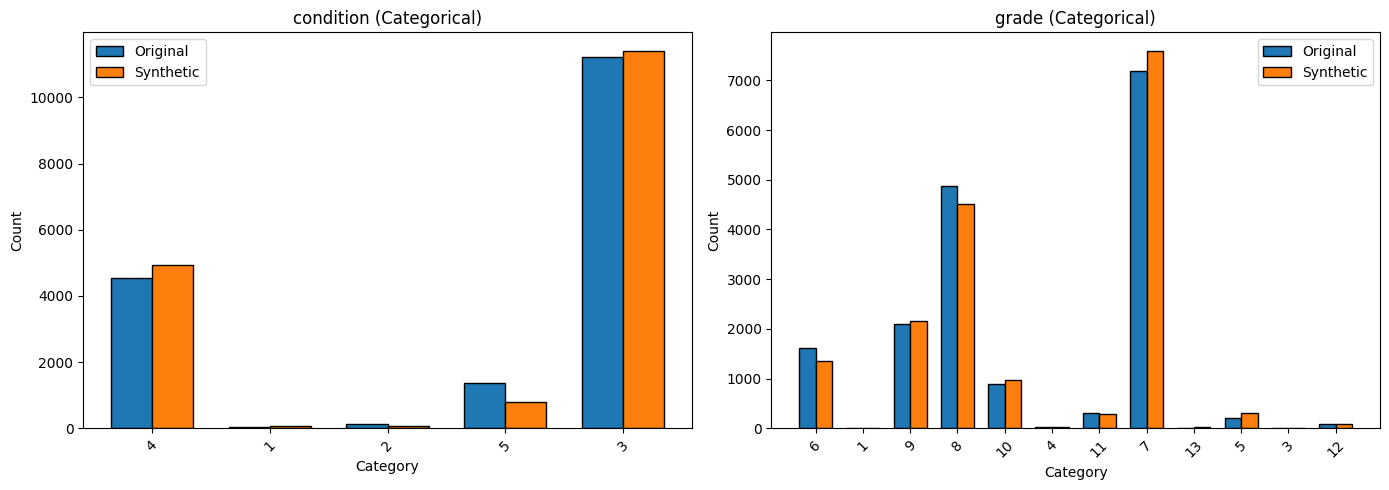

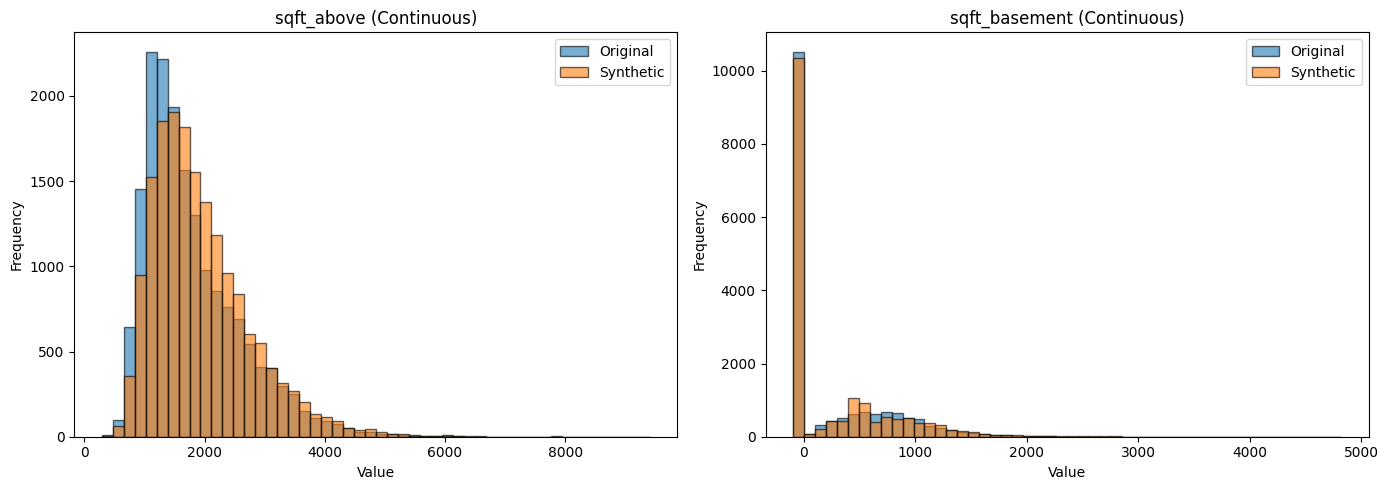

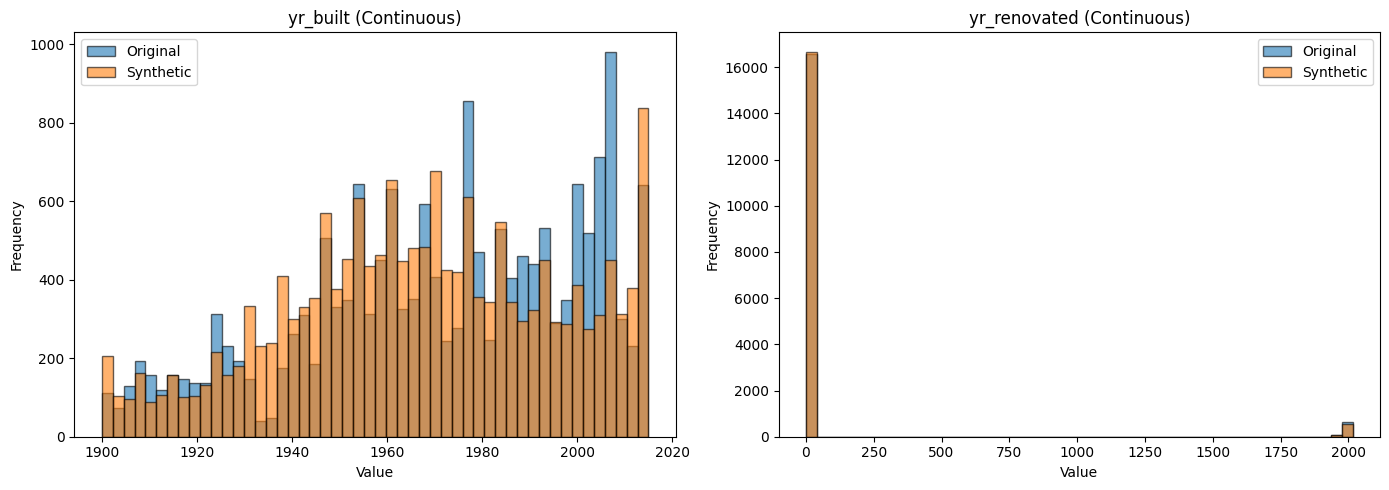

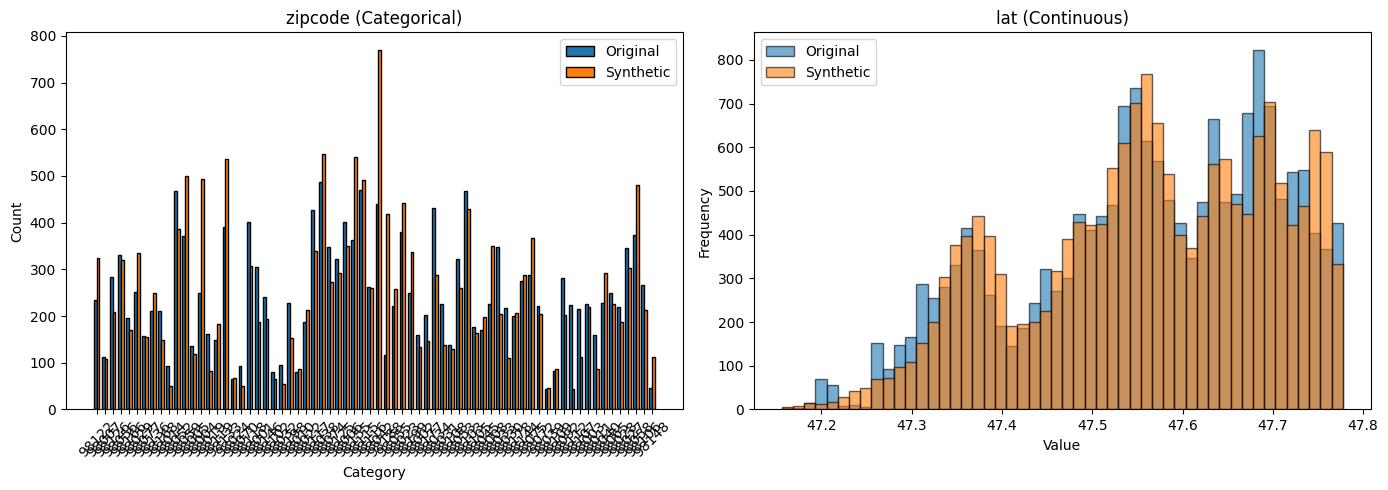

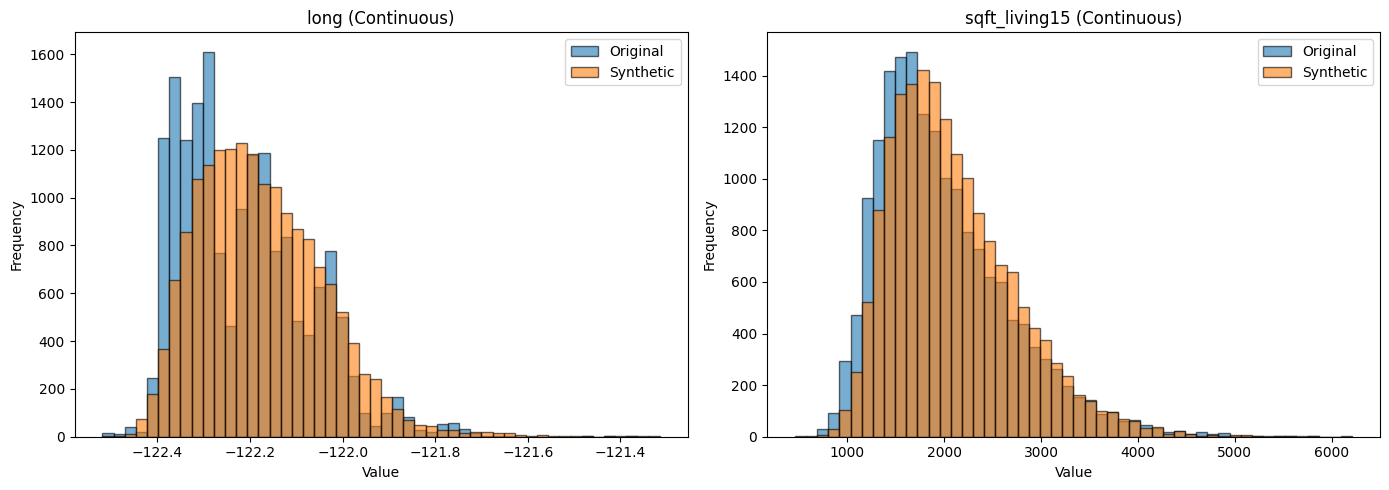

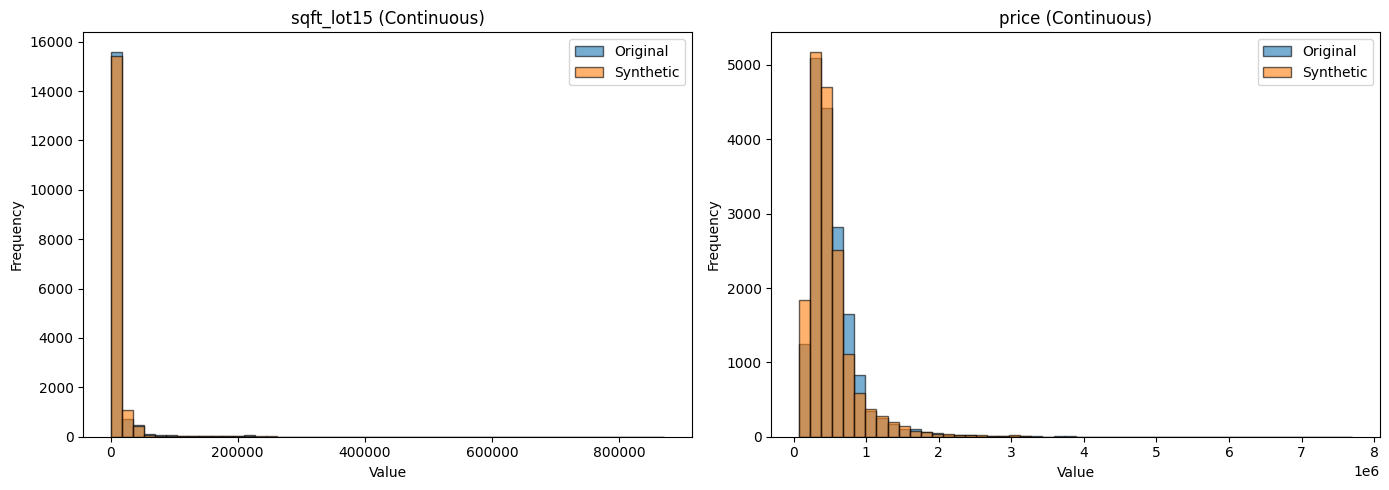

Fake data: ../data_generation/synthetic_data/king_epochs_100_epsilon_15.csv


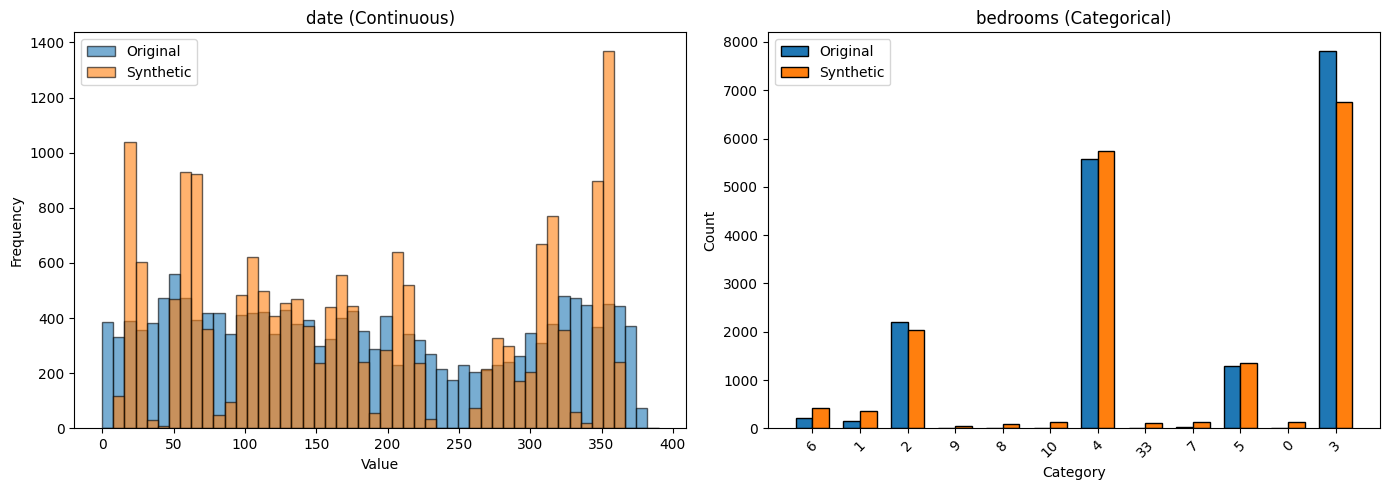

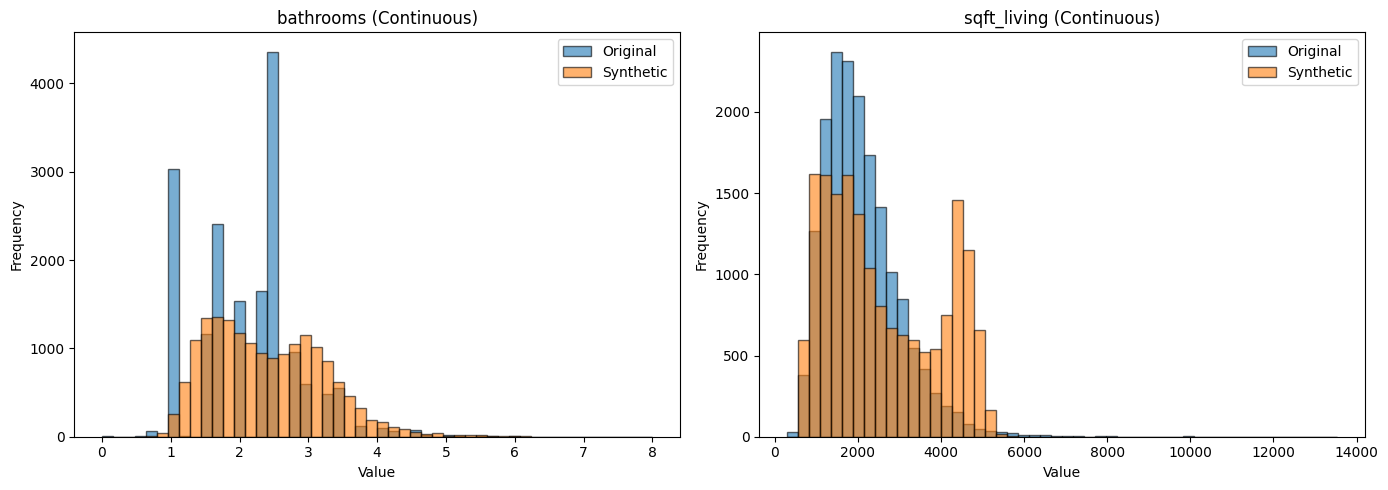

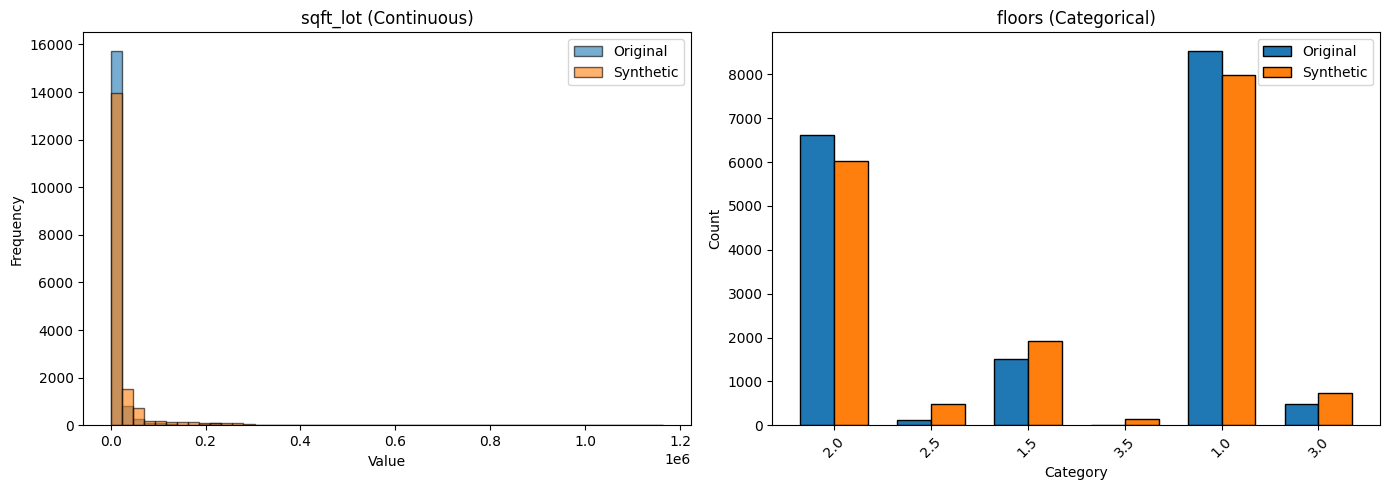

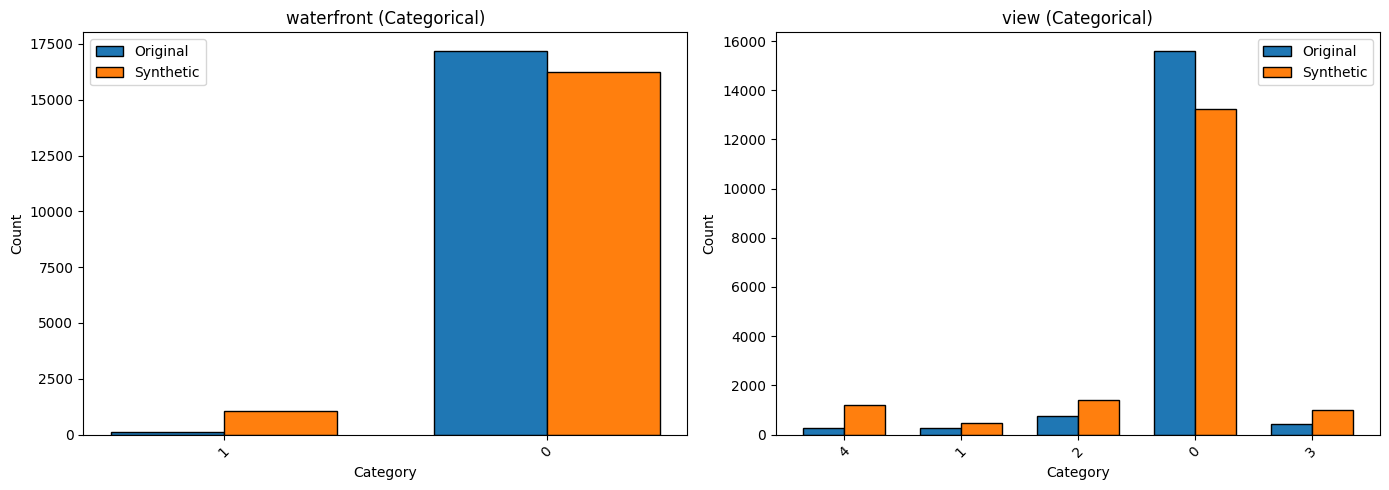

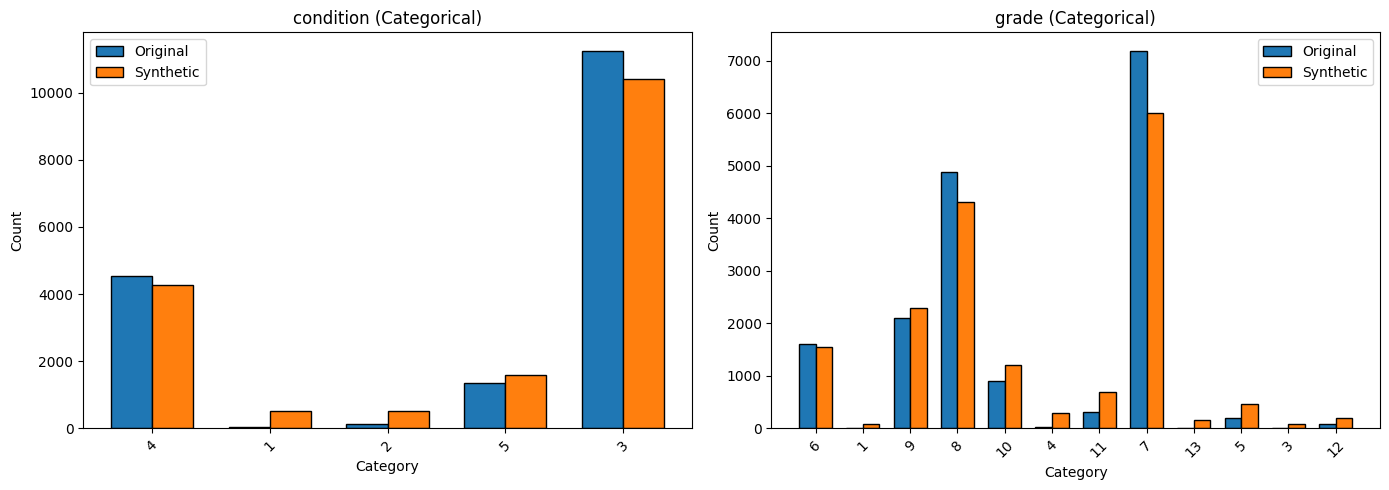

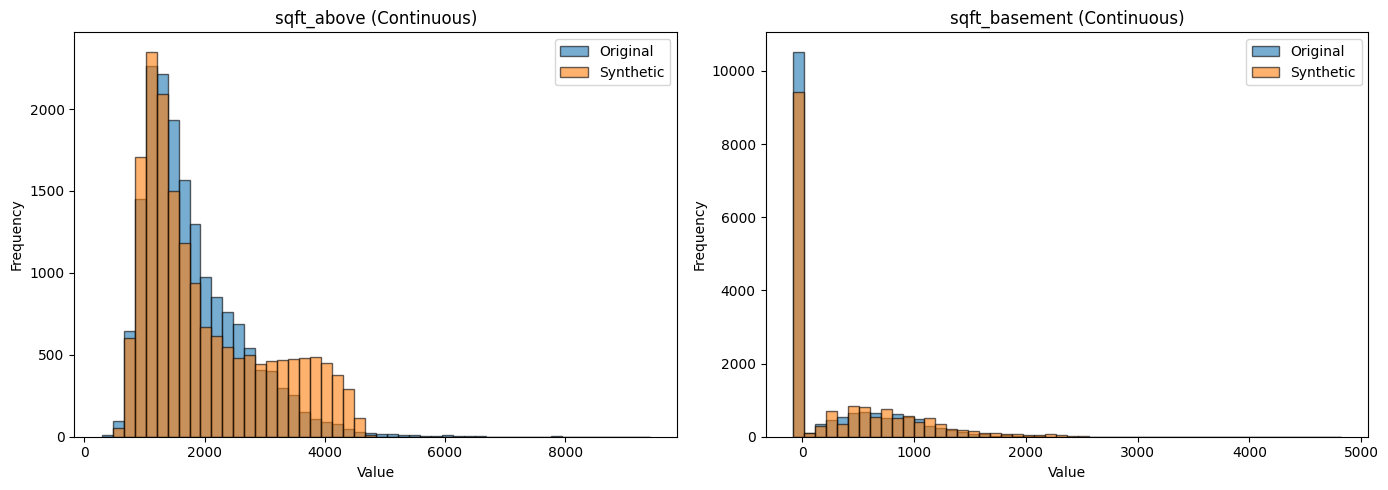

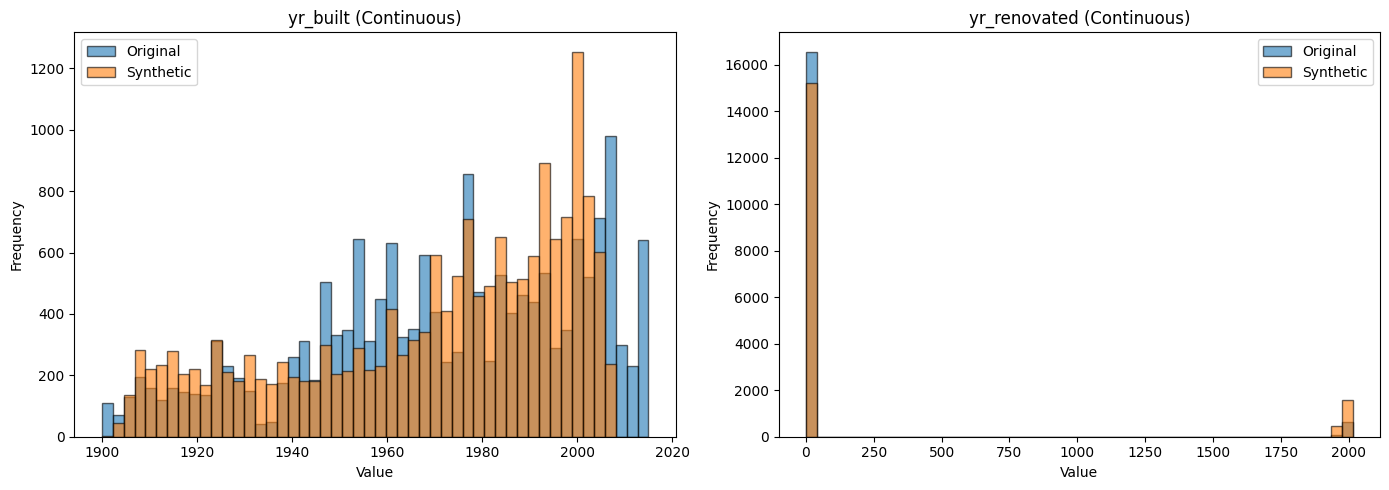

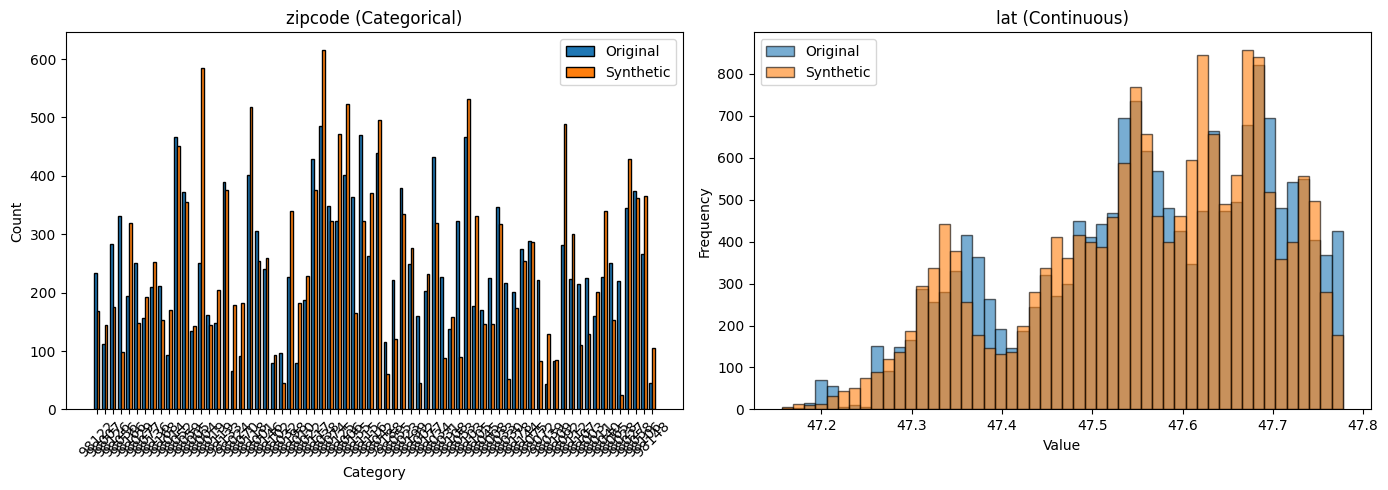

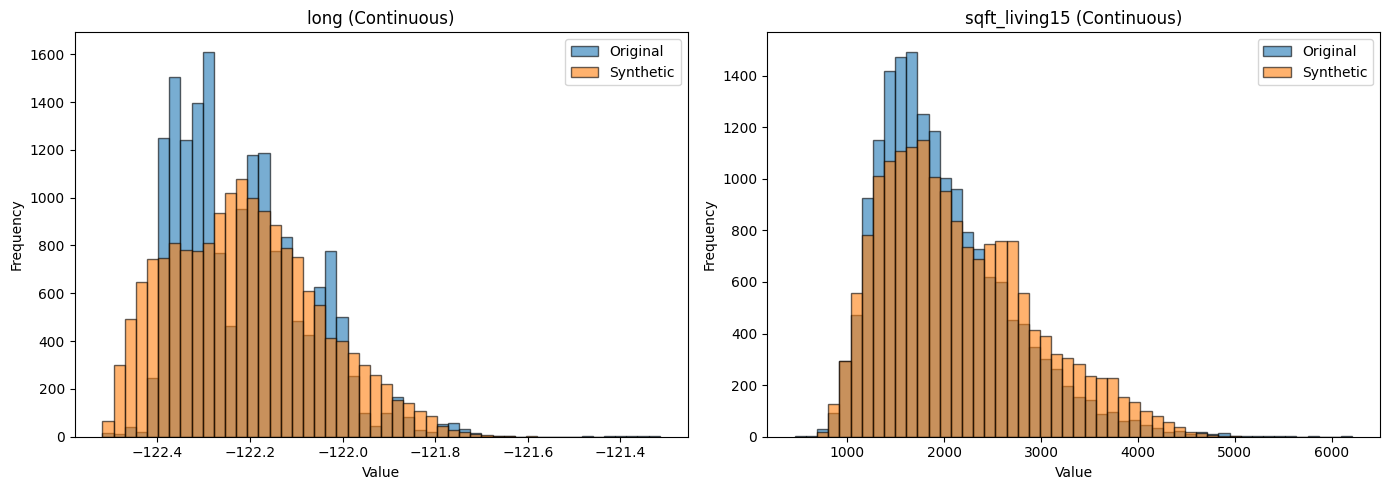

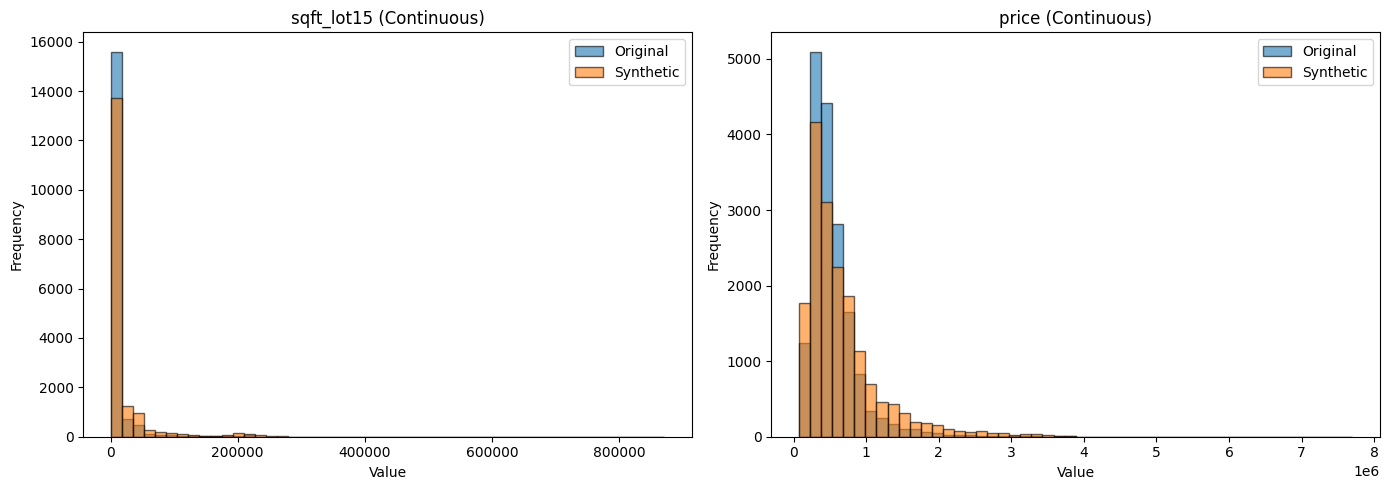

Fake data: ../data_generation/synthetic_data/king_epochs_100_epsilon_5.csv


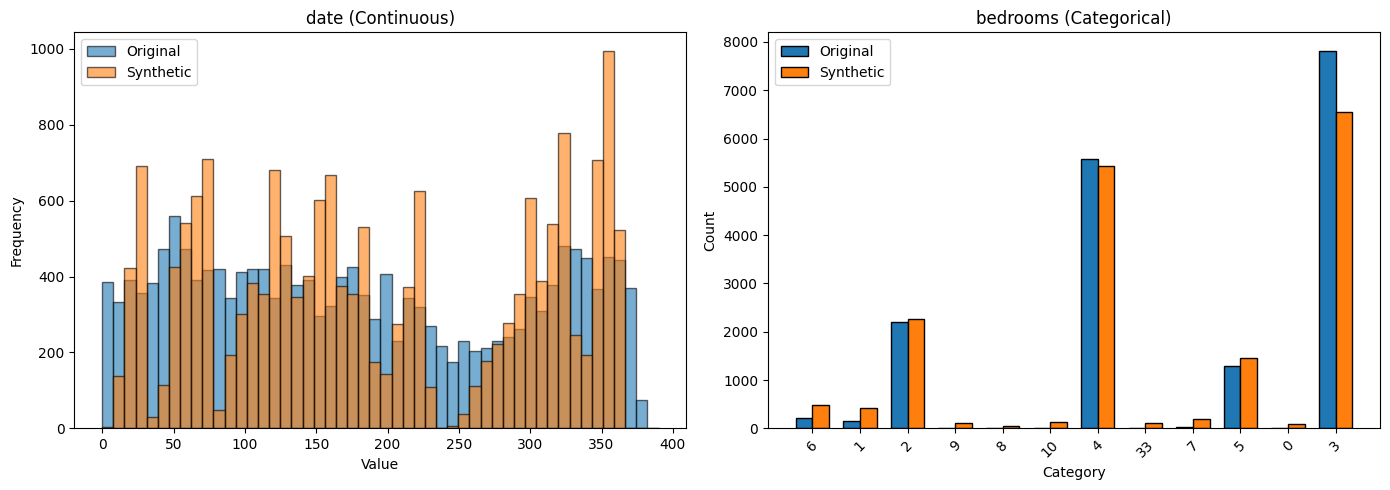

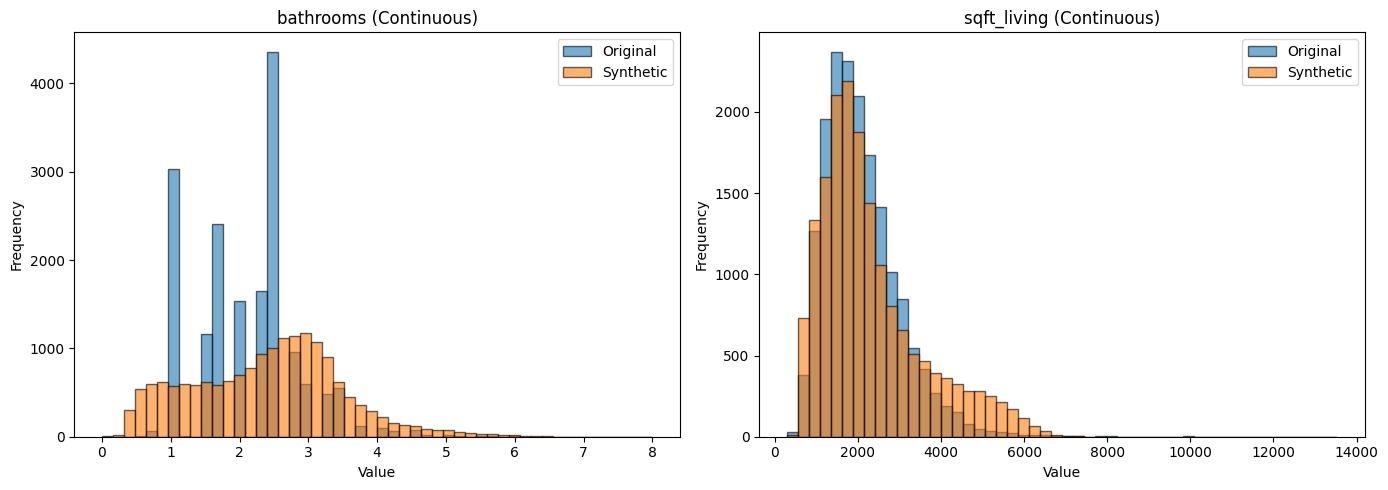

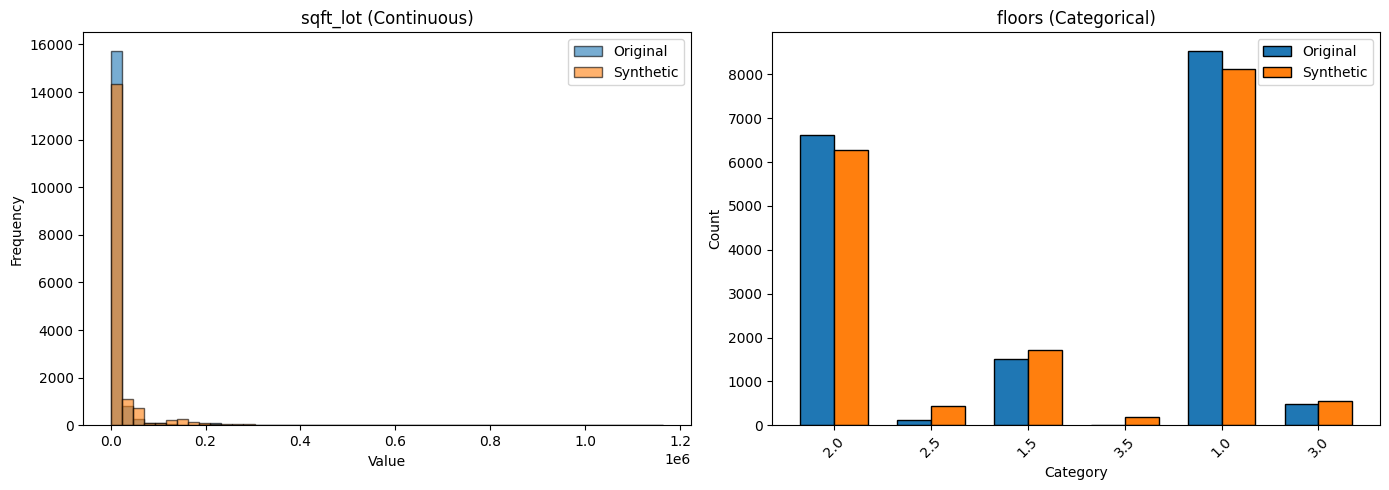

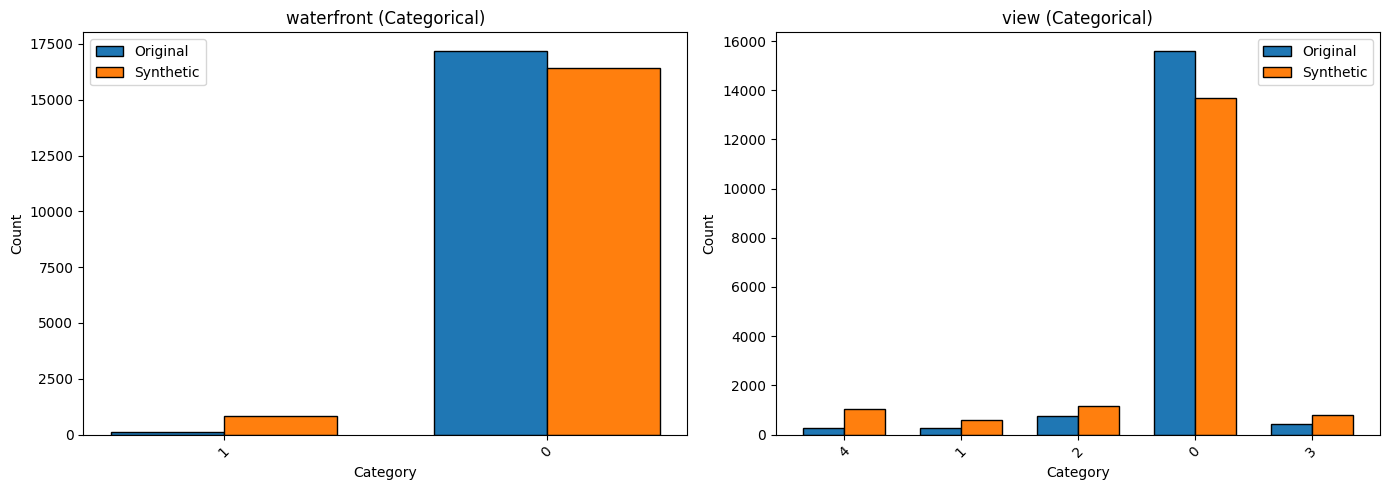

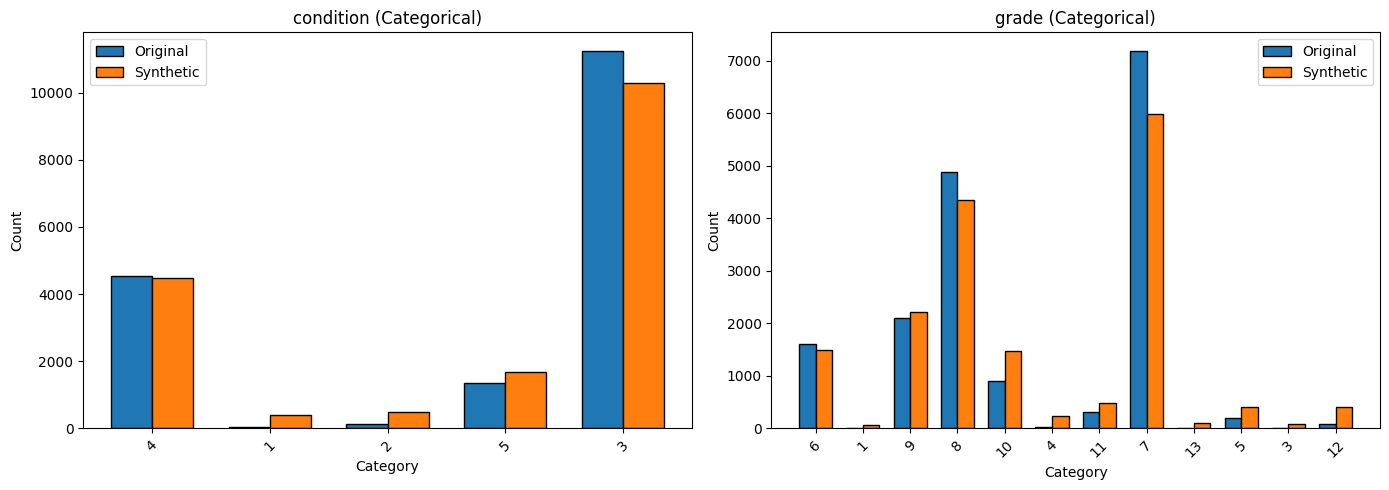

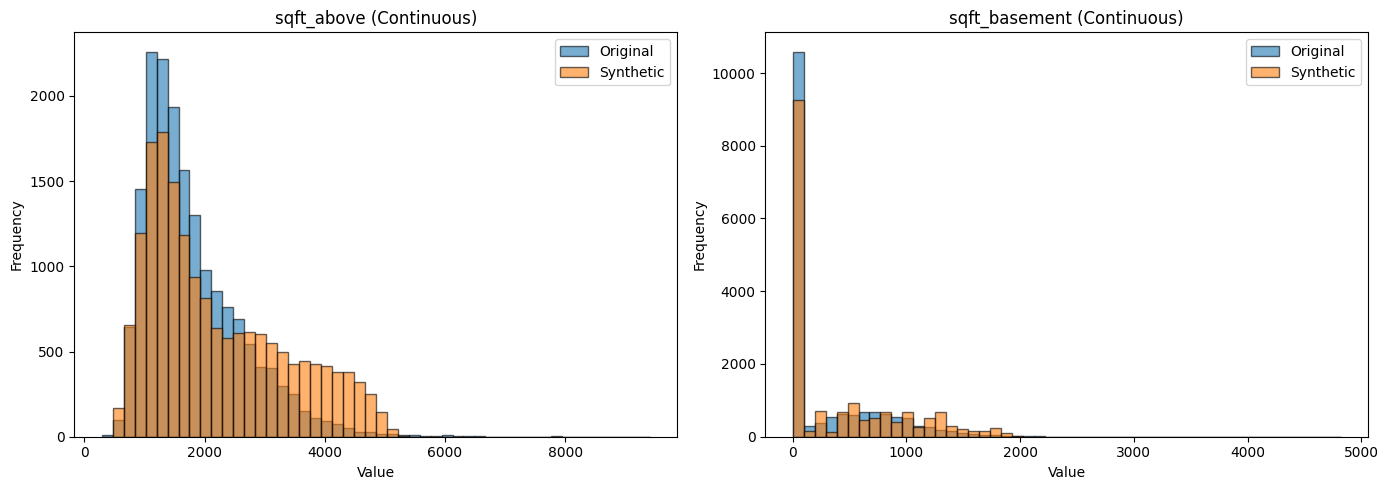

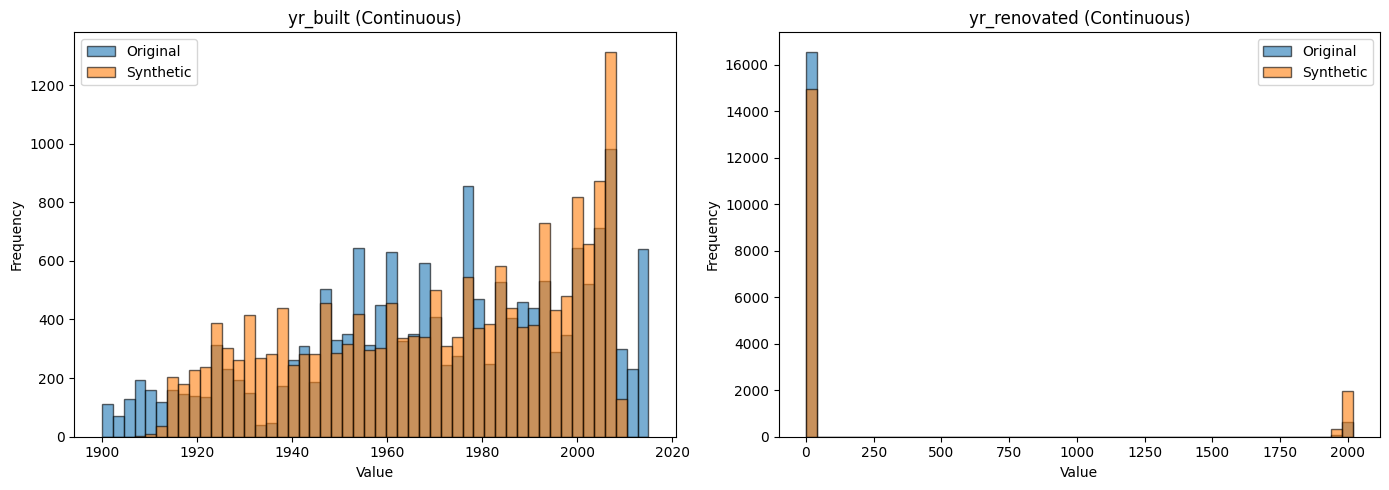

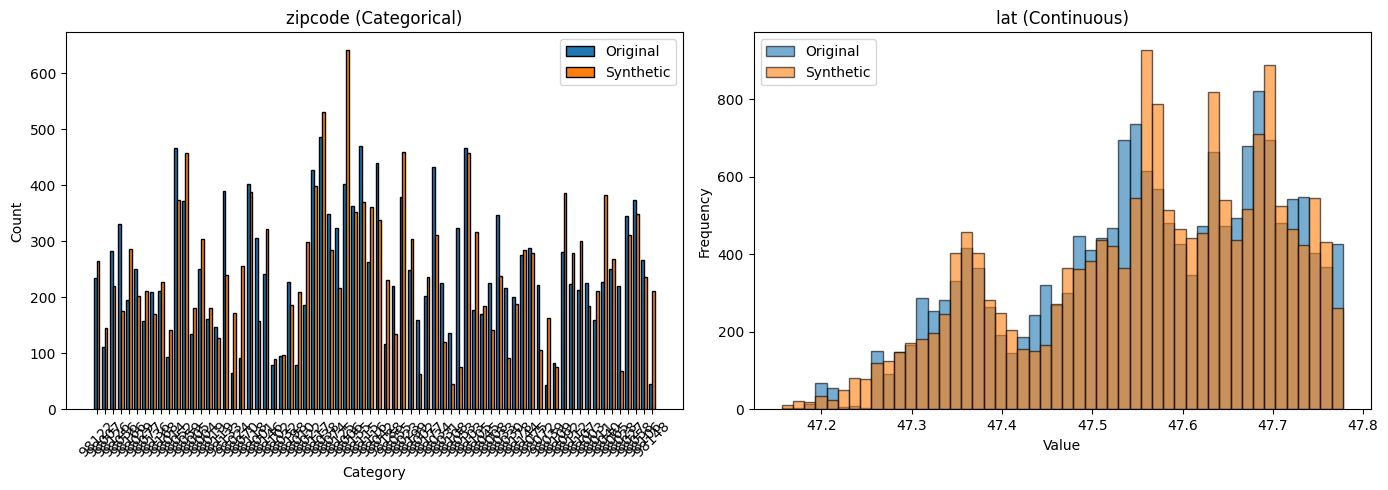

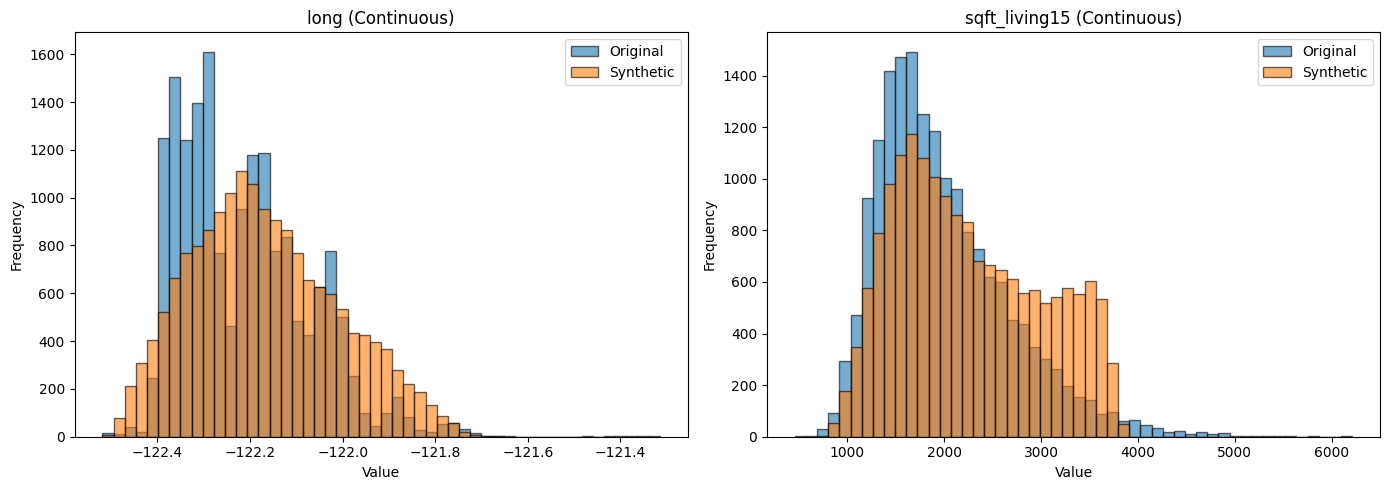

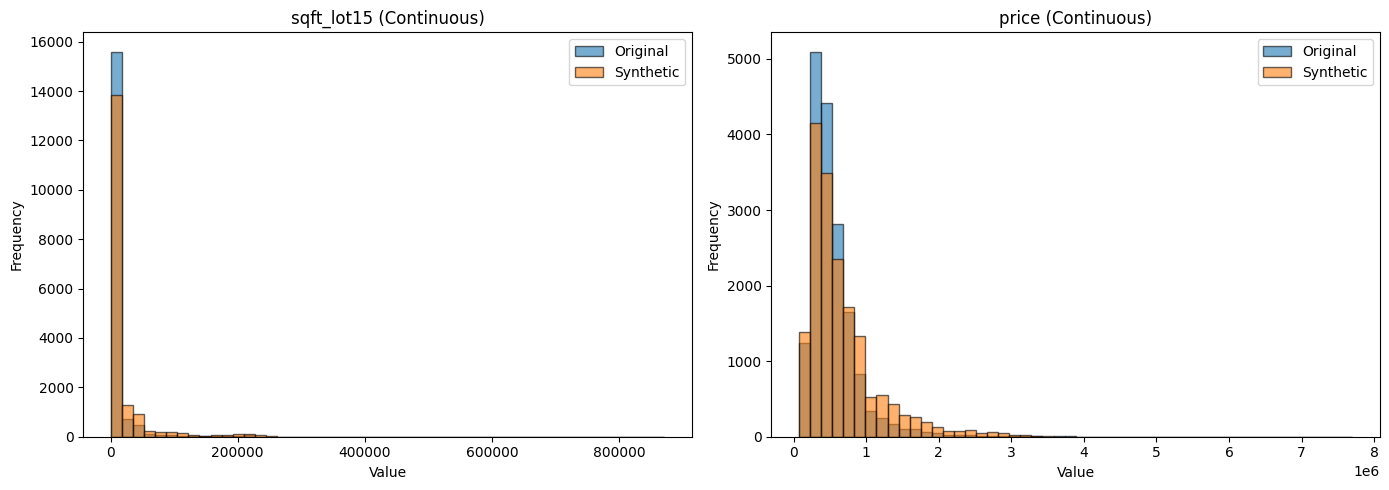

Fake data: ../data_generation/synthetic_data/king_epochs_100_epsilon_1.csv


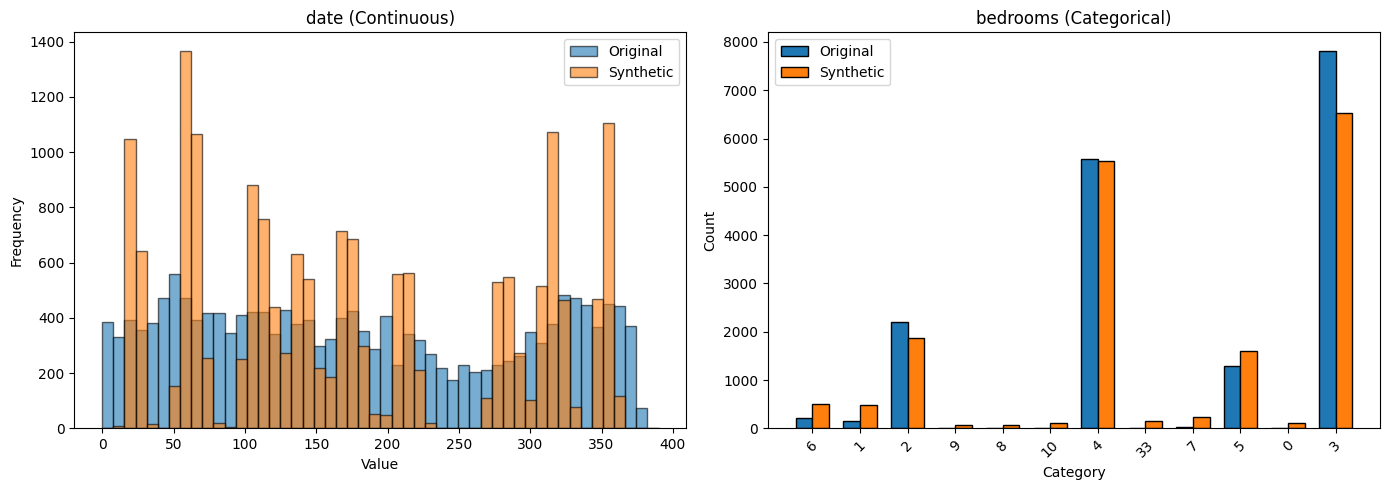

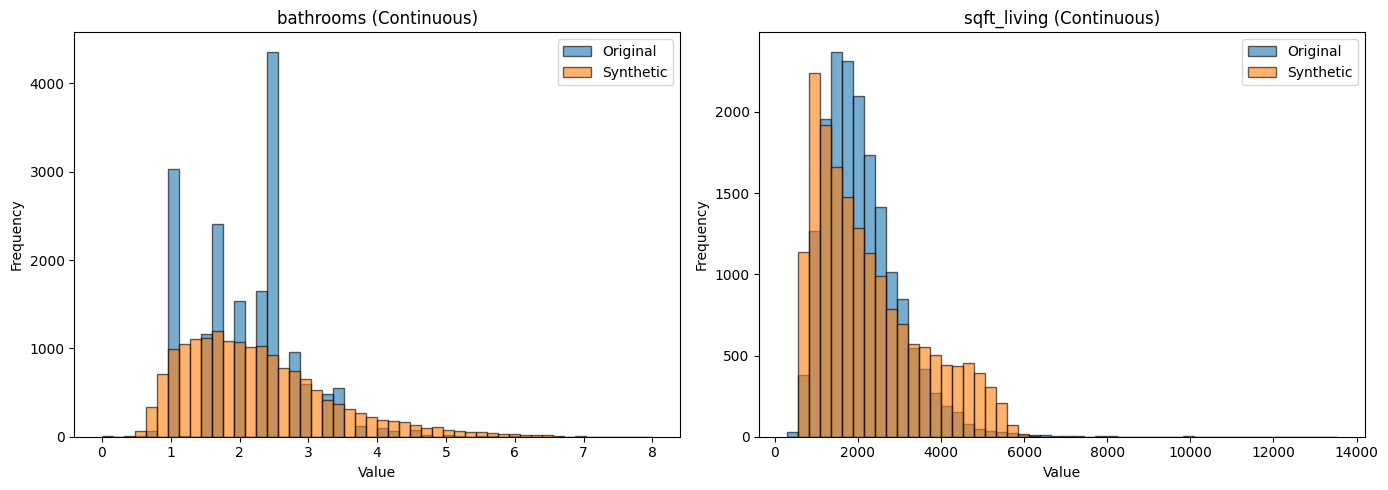

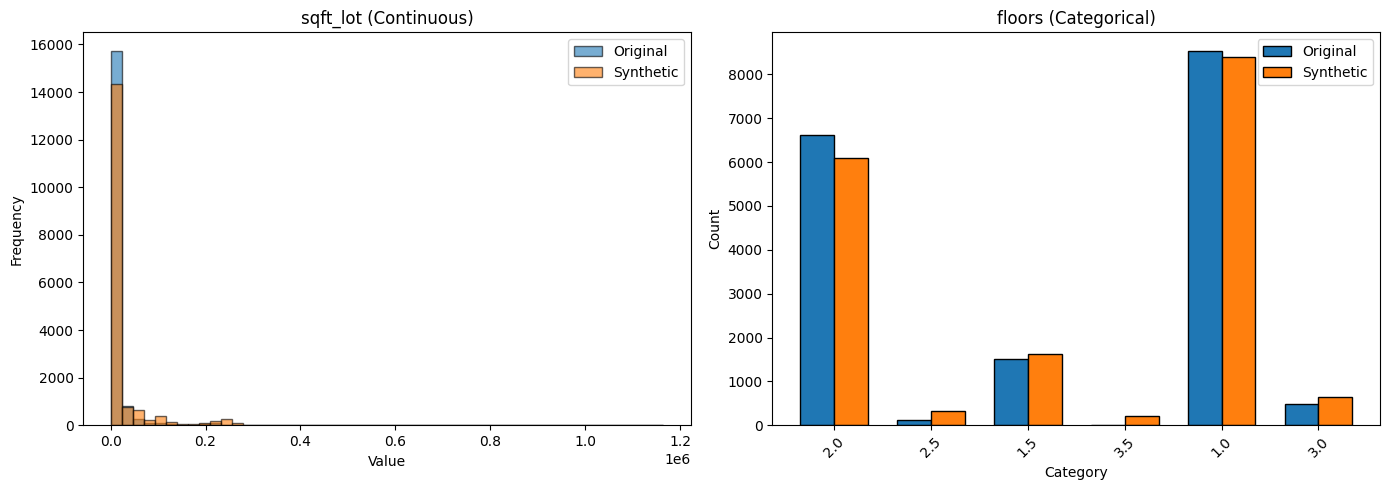

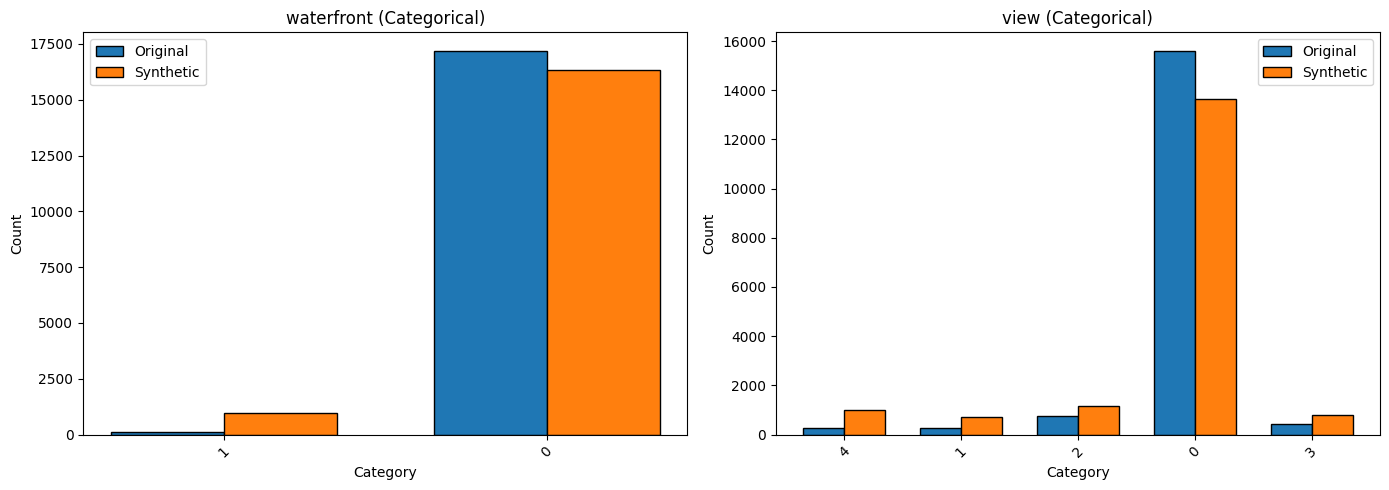

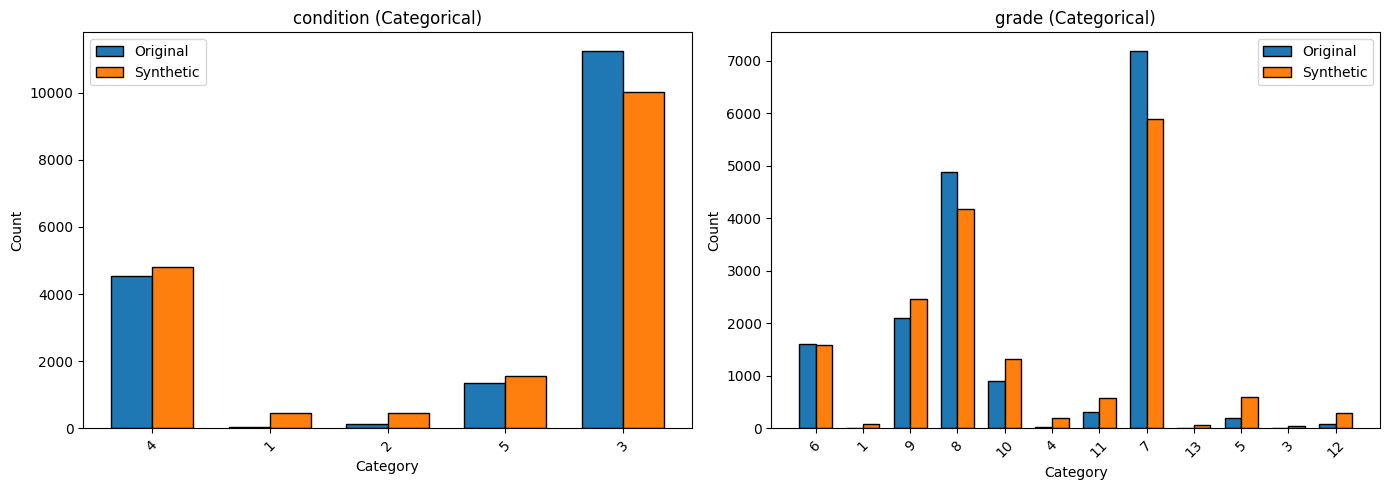

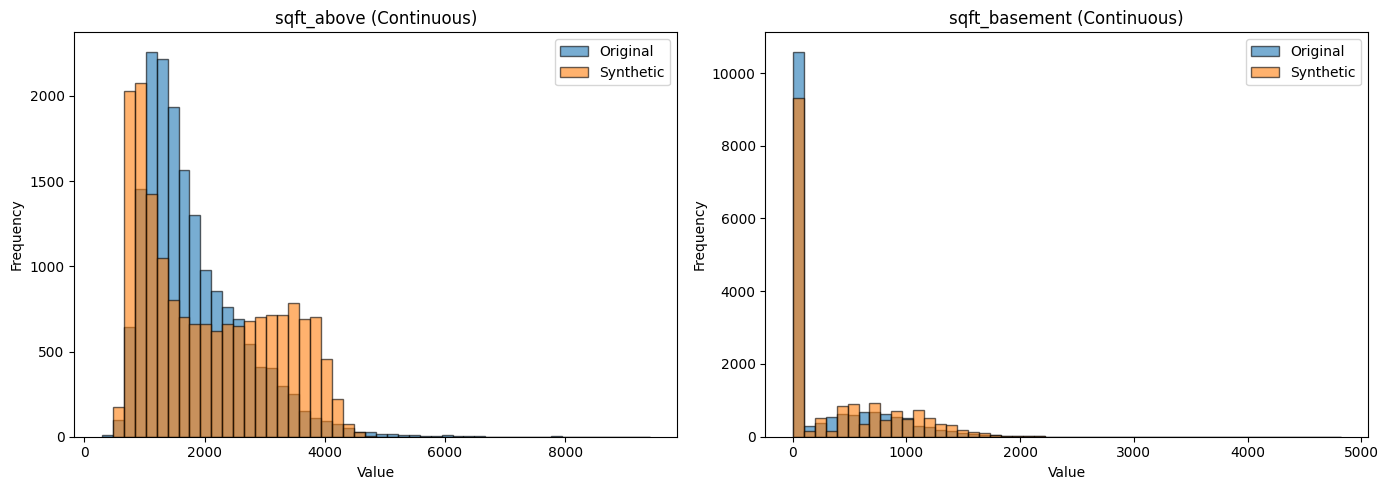

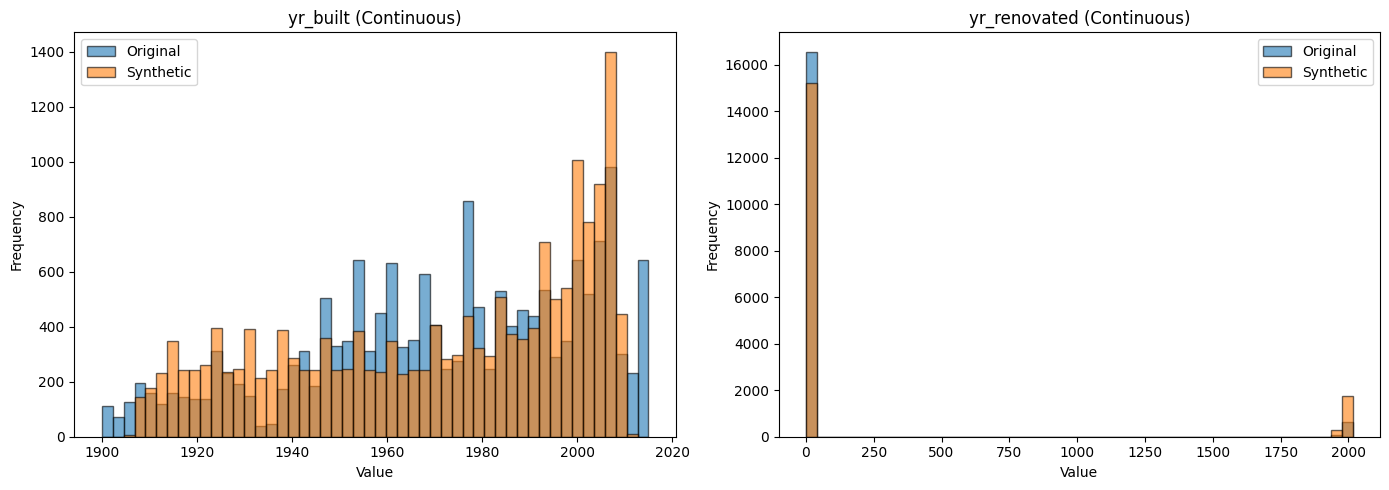

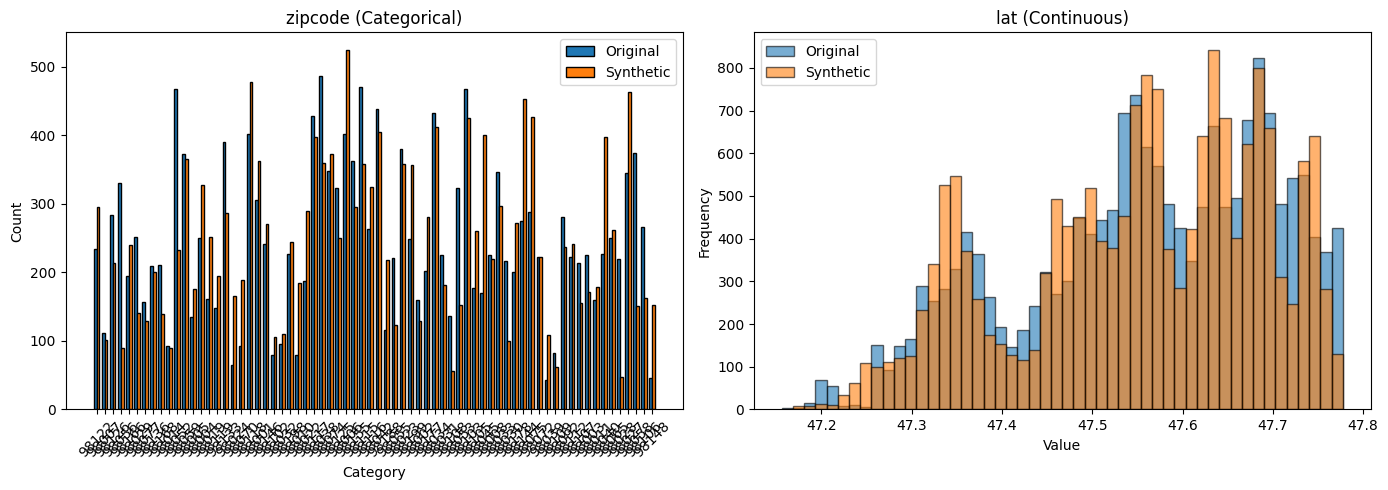

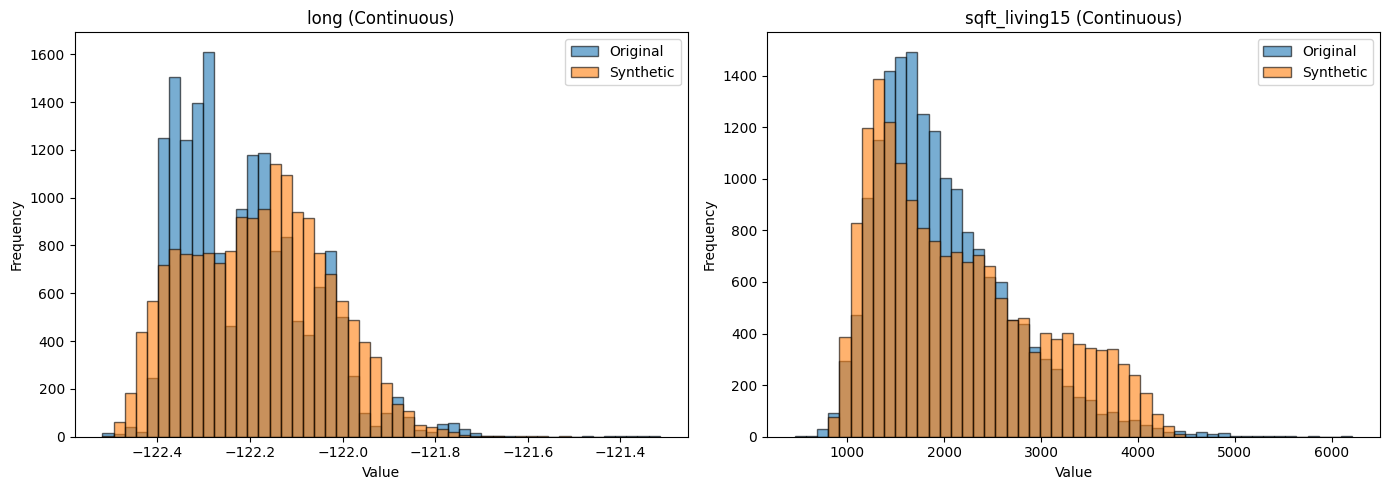

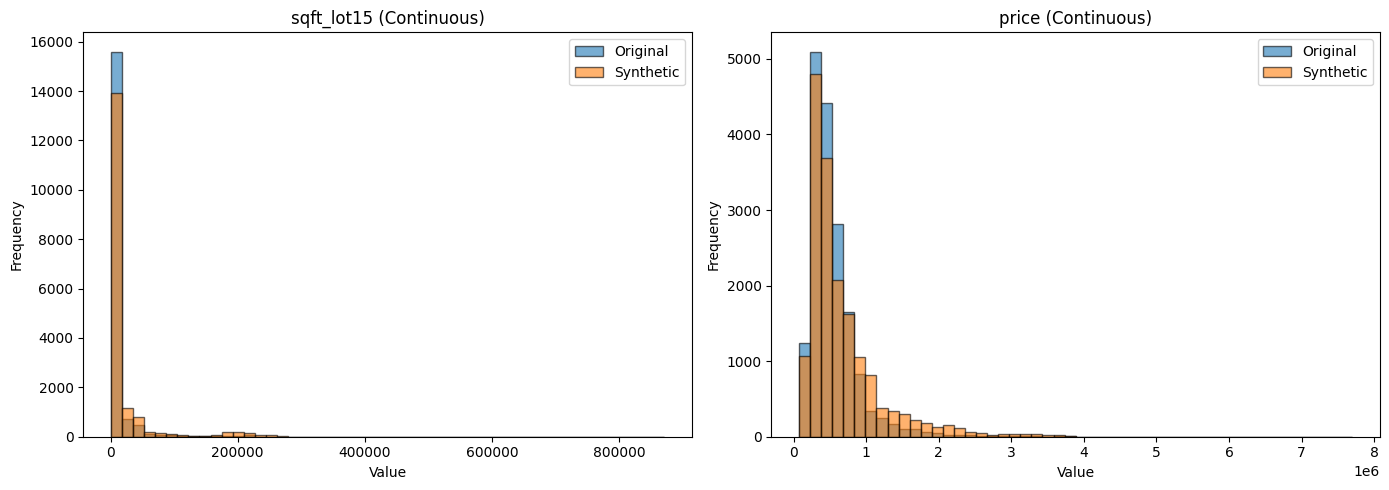

In [5]:



real = pd.read_csv('../datasets/king.csv')

categorical_columns = ['bedrooms', "floors", 'waterfront', 'view', 'condition', 'grade','zipcode']

train, test = evaluation.split_data(real, 0.2, "price",random_state=22,problem='regression')

fakes = [
    '../data_generation/synthetic_data/king_epochs_100_epsilon_None.csv',
    '../data_generation/synthetic_data/king_epochs_100_epsilon_15.csv',
    '../data_generation/synthetic_data/king_epochs_100_epsilon_5.csv',
    '../data_generation/synthetic_data/king_epochs_100_epsilon_1.csv',
]



for fake_path in fakes:
    fake = pd.read_csv(fake_path)
    print(f'Fake data: {fake_path}')
    evaluation.compare_dataframes(train,fake,{},categorical_columns=categorical_columns)

Fake data: ../data_generation/synthetic_data/fraud_epochs_100_epsilon_None.csv


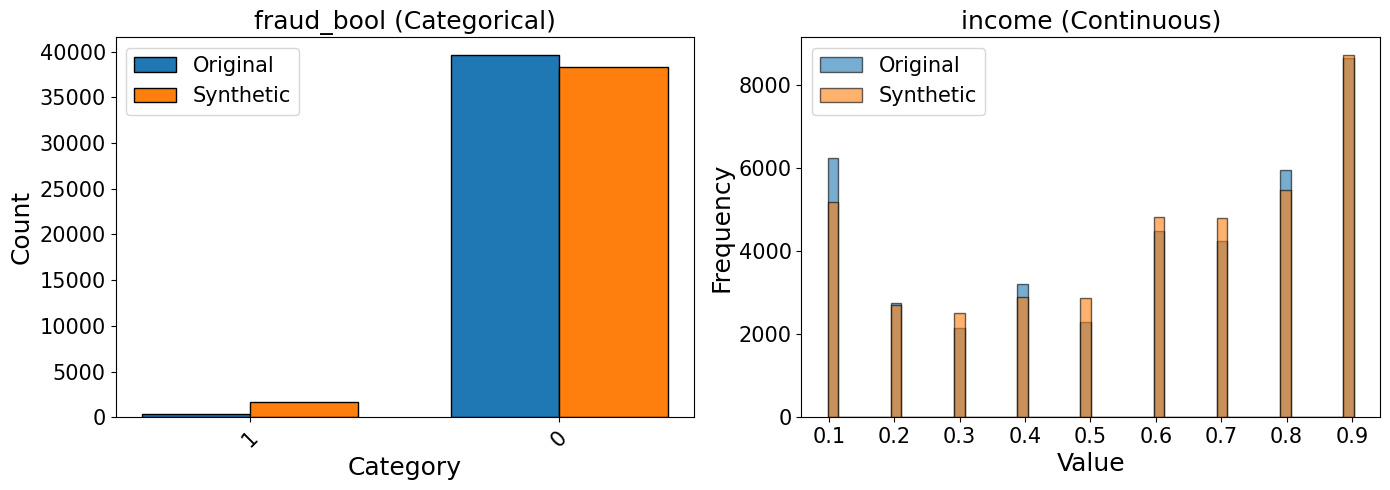

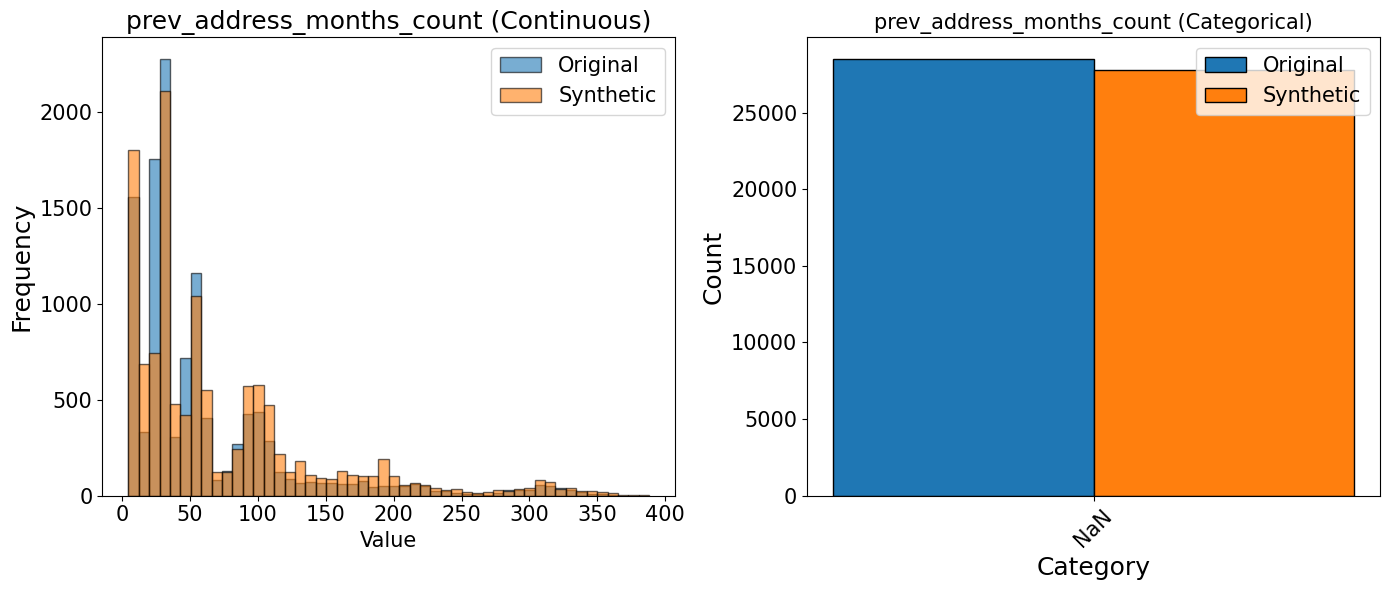

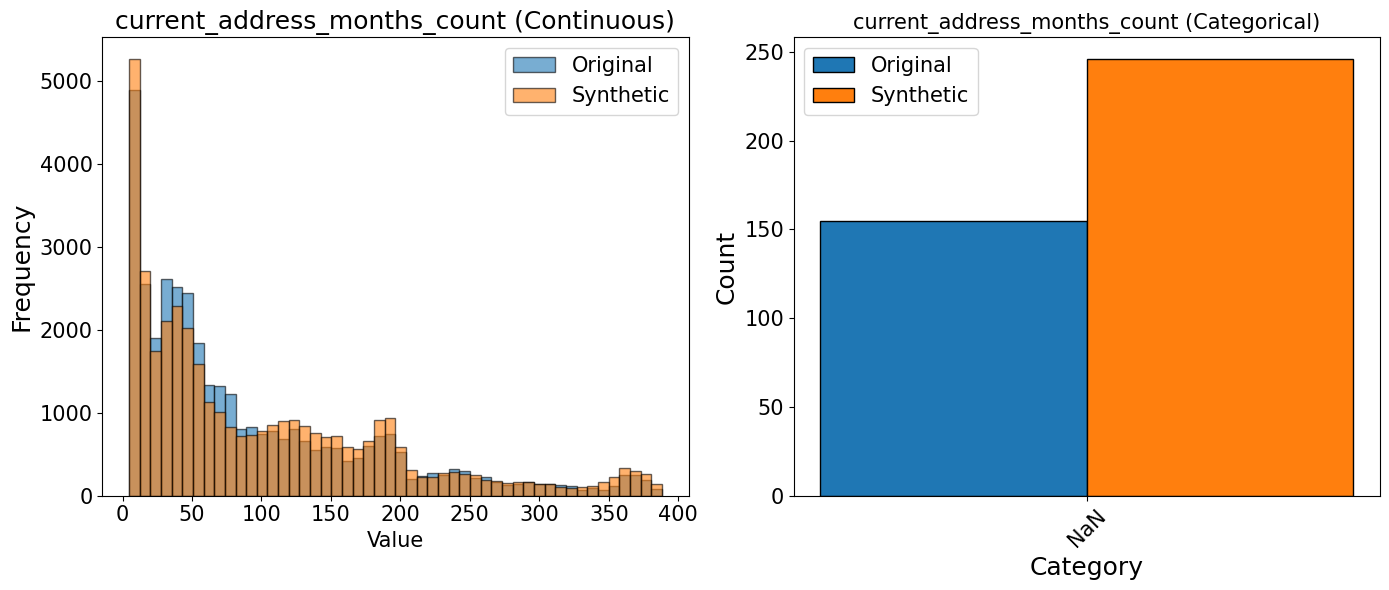

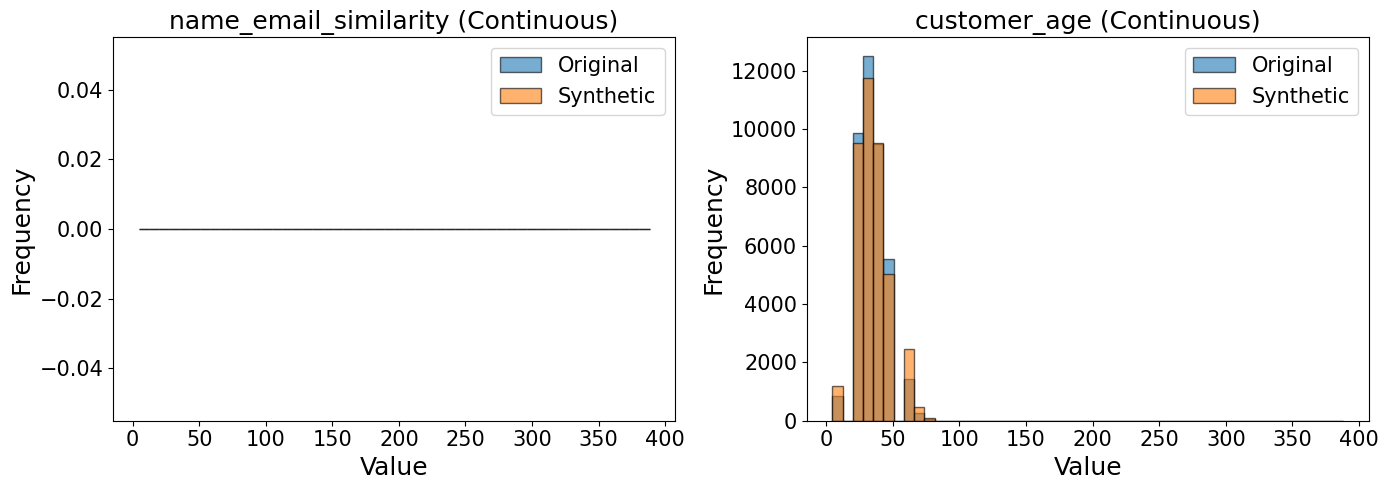

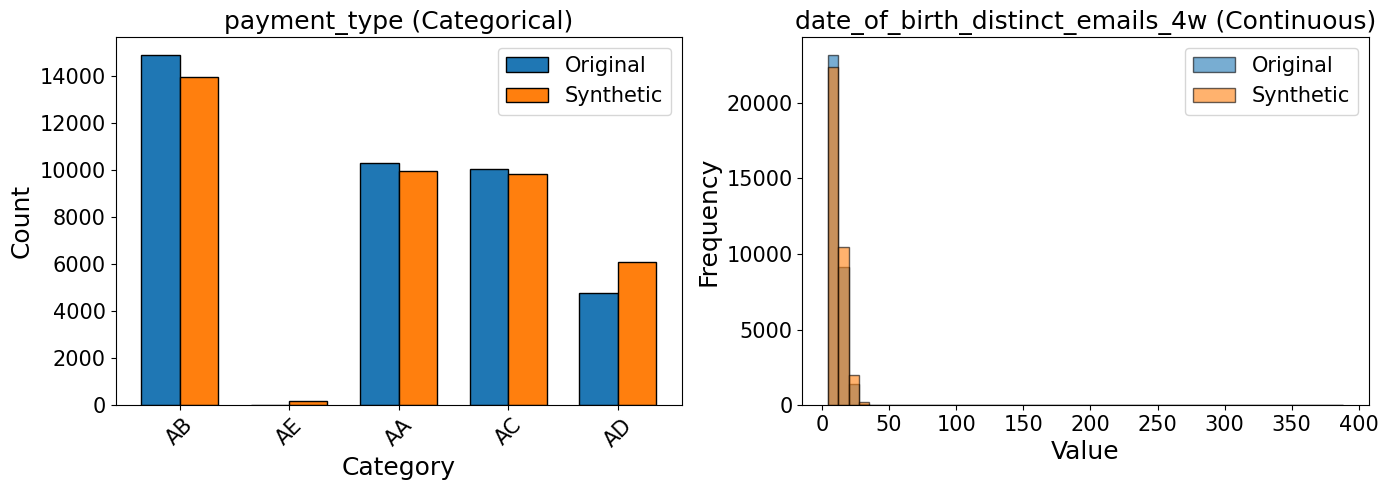

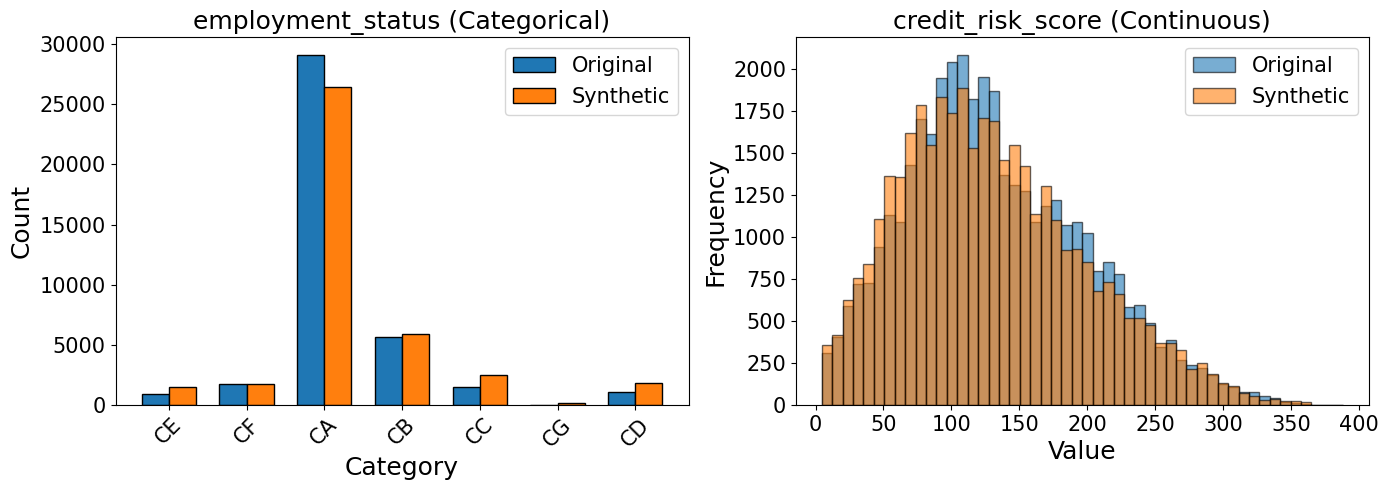

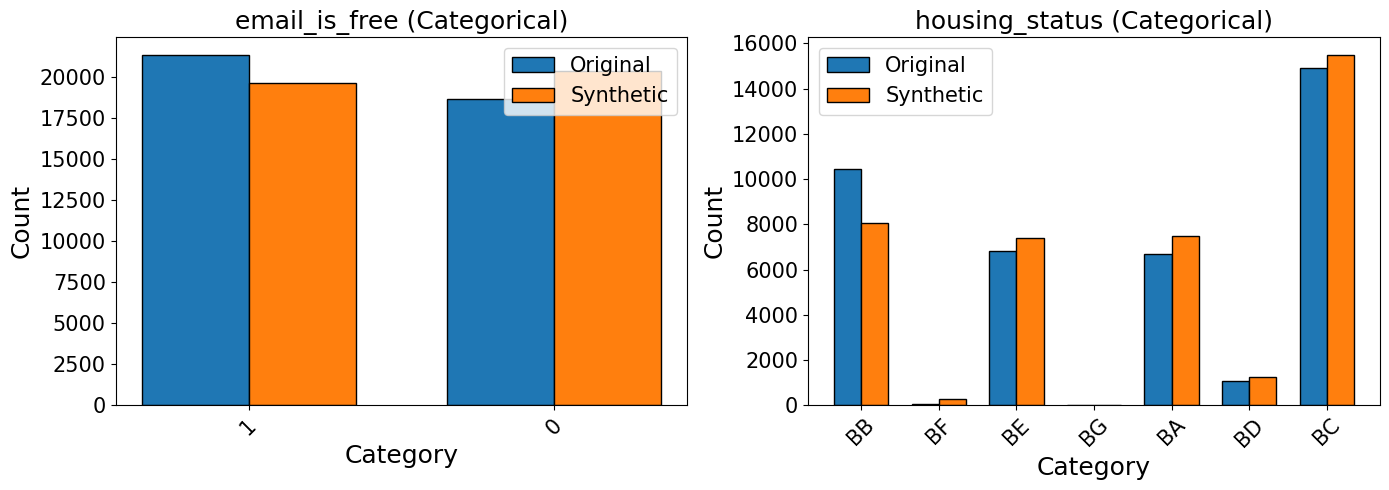

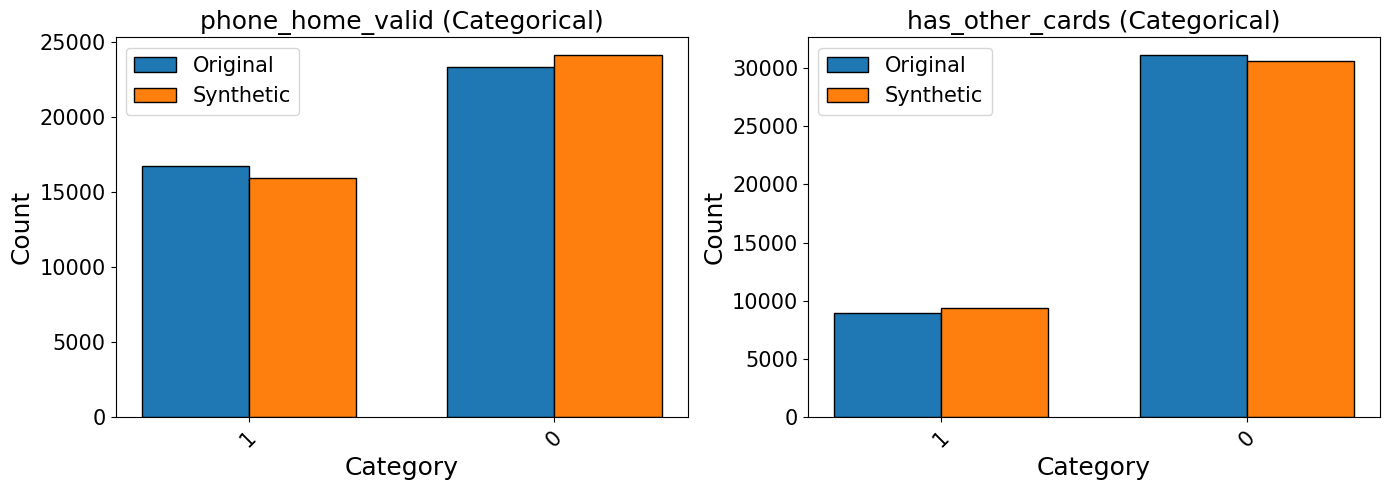

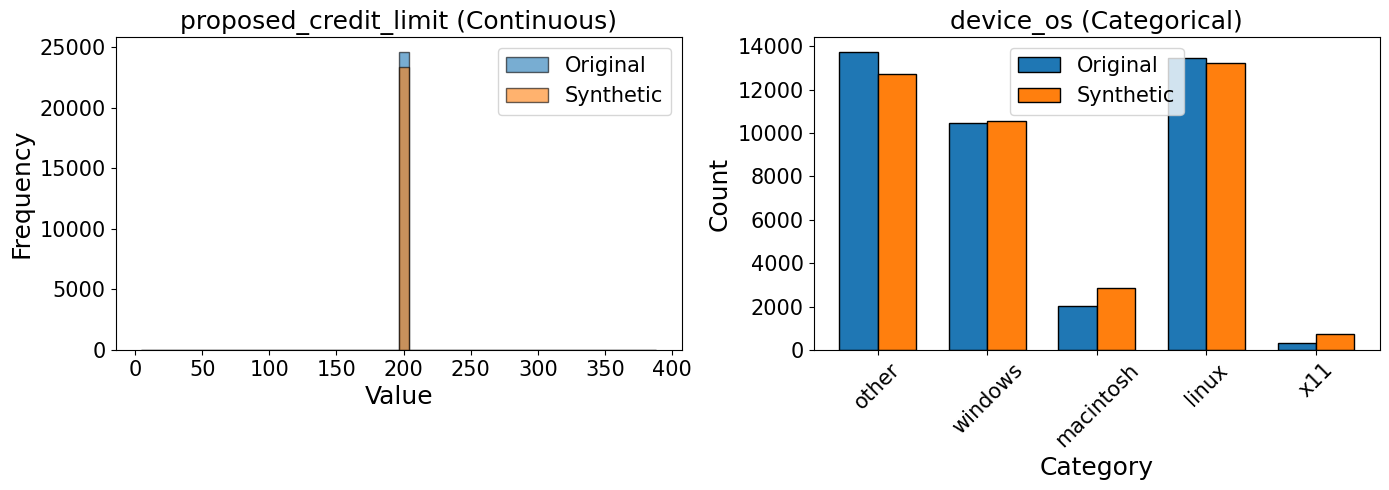

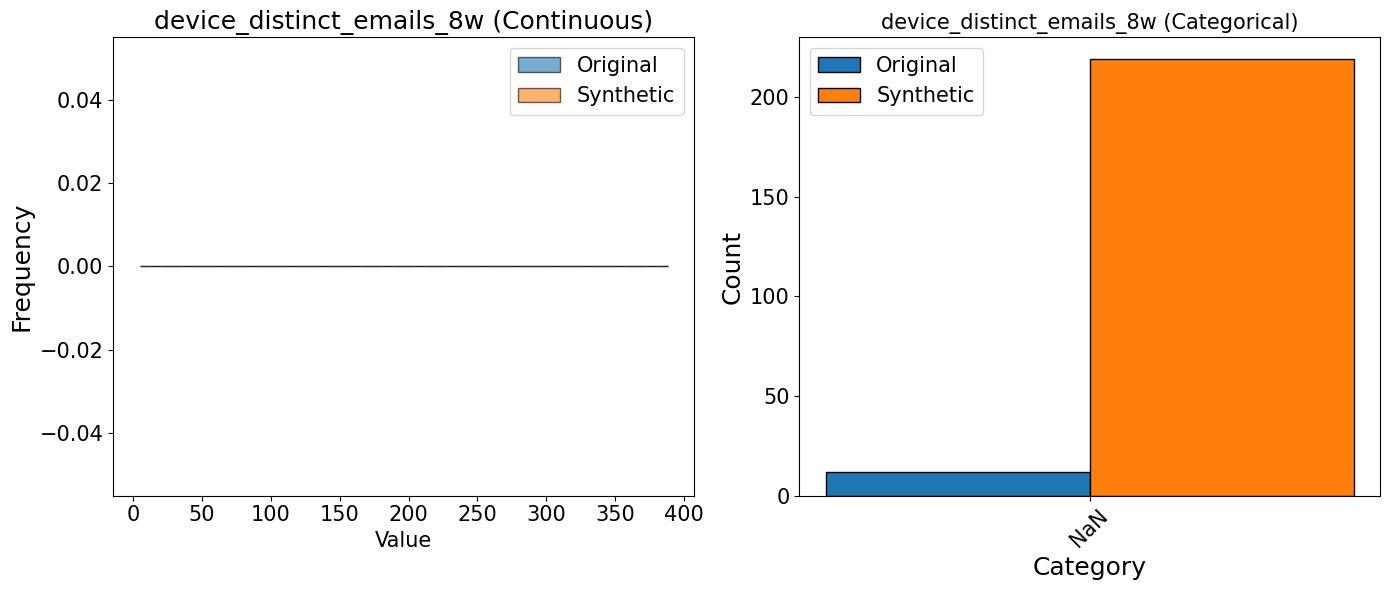

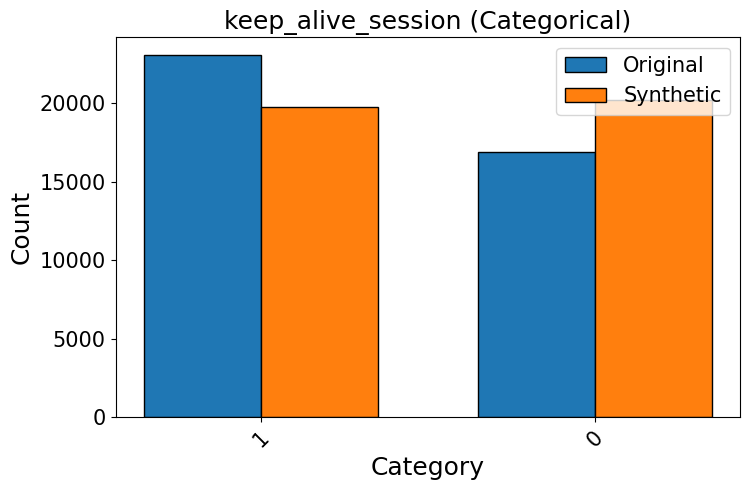

In [6]:

missing_values_columns = ["prev_address_months_count", "current_address_months_count", "device_distinct_emails_8w"]
real = pd.read_csv('../datasets/fraud.csv')
real[missing_values_columns] = real[missing_values_columns].replace(-1, np.nan)

categorical_columns =  ["fraud_bool","payment_type","employment_status","email_is_free","housing_status","device_os","phone_home_valid","has_other_cards","keep_alive_session"]

train, test = evaluation.split_data(real, 0.2, "fraud_bool",random_state=22)

fakes = [
    '../data_generation/synthetic_data/fraud_epochs_100_epsilon_None.csv',
    '../data_generation/synthetic_data/fraud_epochs_100_epsilon_15.csv',
    '../data_generation/synthetic_data/fraud_epochs_100_epsilon_5.csv',
    '../data_generation/synthetic_data/fraud_epochs_100_epsilon_1.csv',
]





for fake_path in fakes:
    fake = pd.read_csv(fake_path)
    fake[missing_values_columns] = fake[missing_values_columns].replace(-1, np.nan)
    print(f'Fake data: {fake_path}')
    compare_dataframes(train,fake,{"prev_address_months_count":[np.nan], "current_address_months_count":[np.nan], "device_distinct_emails_8w":[np.nan]},categorical_columns=categorical_columns)
    break


